# Imports

## Libraries

In [1]:
### Basic Libraries
# !pip install numpy
import numpy as np
# !pip install pandas
import pandas as pd

### Visualization
# !pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install seaborn
import seaborn as sns
sns.set()
sns.set_theme(context='talk', palette='Dark2')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

### Sklearn
# !pip install scikit-learn
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer #StandardScaler
from sklearn.metrics import confusion_matrix

### Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
# !pip install umap-learn
import umap

### Functions
from utils1 import plot_bar_chart, plot_correlation_matrix, data_transform
from utils2 import (
    apply_optimal_knnimputer,
    pc_analysis,
    plot_inertia_and_silhouette,
    plot_r2_hc,
    plot_dendrogram,
    clusters_comparison,
    groupby_mean,
    visualize_dimensionality_reduction, 
)

### Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Path
temp_path = 'temp\\'

### Autoreload
%load_ext autoreload
%autoreload 2

## Data

In [2]:
data = pd.read_csv('data.csv', index_col=0)

In [3]:
data

Course area_Art  Course area_Business sciences  \
Userid                                                   
699               False                          False   
456               False                          False   
647               False                          False   
383               False                          False   
1217              False                          False   
...                 ...                            ...   
4144              False                          False   
2761              False                          False   
4410              False                           True   
259               False                          False   
1292              False                          False   

        Course area_Engineering and related techniques  Course area_Health  \
Userid                                                                       
699                                              False               False   
456                                              False               False   
647                                              False               False   
383                                              False               False   
1217                                             False               False   
...                                                ...                 ...   
4144                                             False                True   
2761                                             False                True   
4410                                             False               False   
259                                              False               False   
1292                                             False                True   

        Course area_Information and journalism  Course area_Personal services  \
Userid                                                                          
699                                      False                          False   
456                                      False                          False   
647                                      False                          False   
383                                      False                          False   
1217                                     False                          False   
...                                        ...                            ...   
4144                                     False                          False   
2761                                     False                          False   
4410                                     False                          False   
259                                      False                          False   
1292                                     False                          False   

        Course area_Social services  \
Userid                                
699                           False   
456                            True   
647                            True   
383                            True   
1217                           True   
...                             ...   
4144                          False   
2761                          False   
4410                          False   
259                            True   
1292                          False   

        Course area_Teacher training/trainers and education sciences  \
Userid                                                                 
699                                                 False              
456                                                 False              
647                                                 False              
383                                                 False              
1217                                                False              
...                                                   ...              
4144                                                False              
2761                        

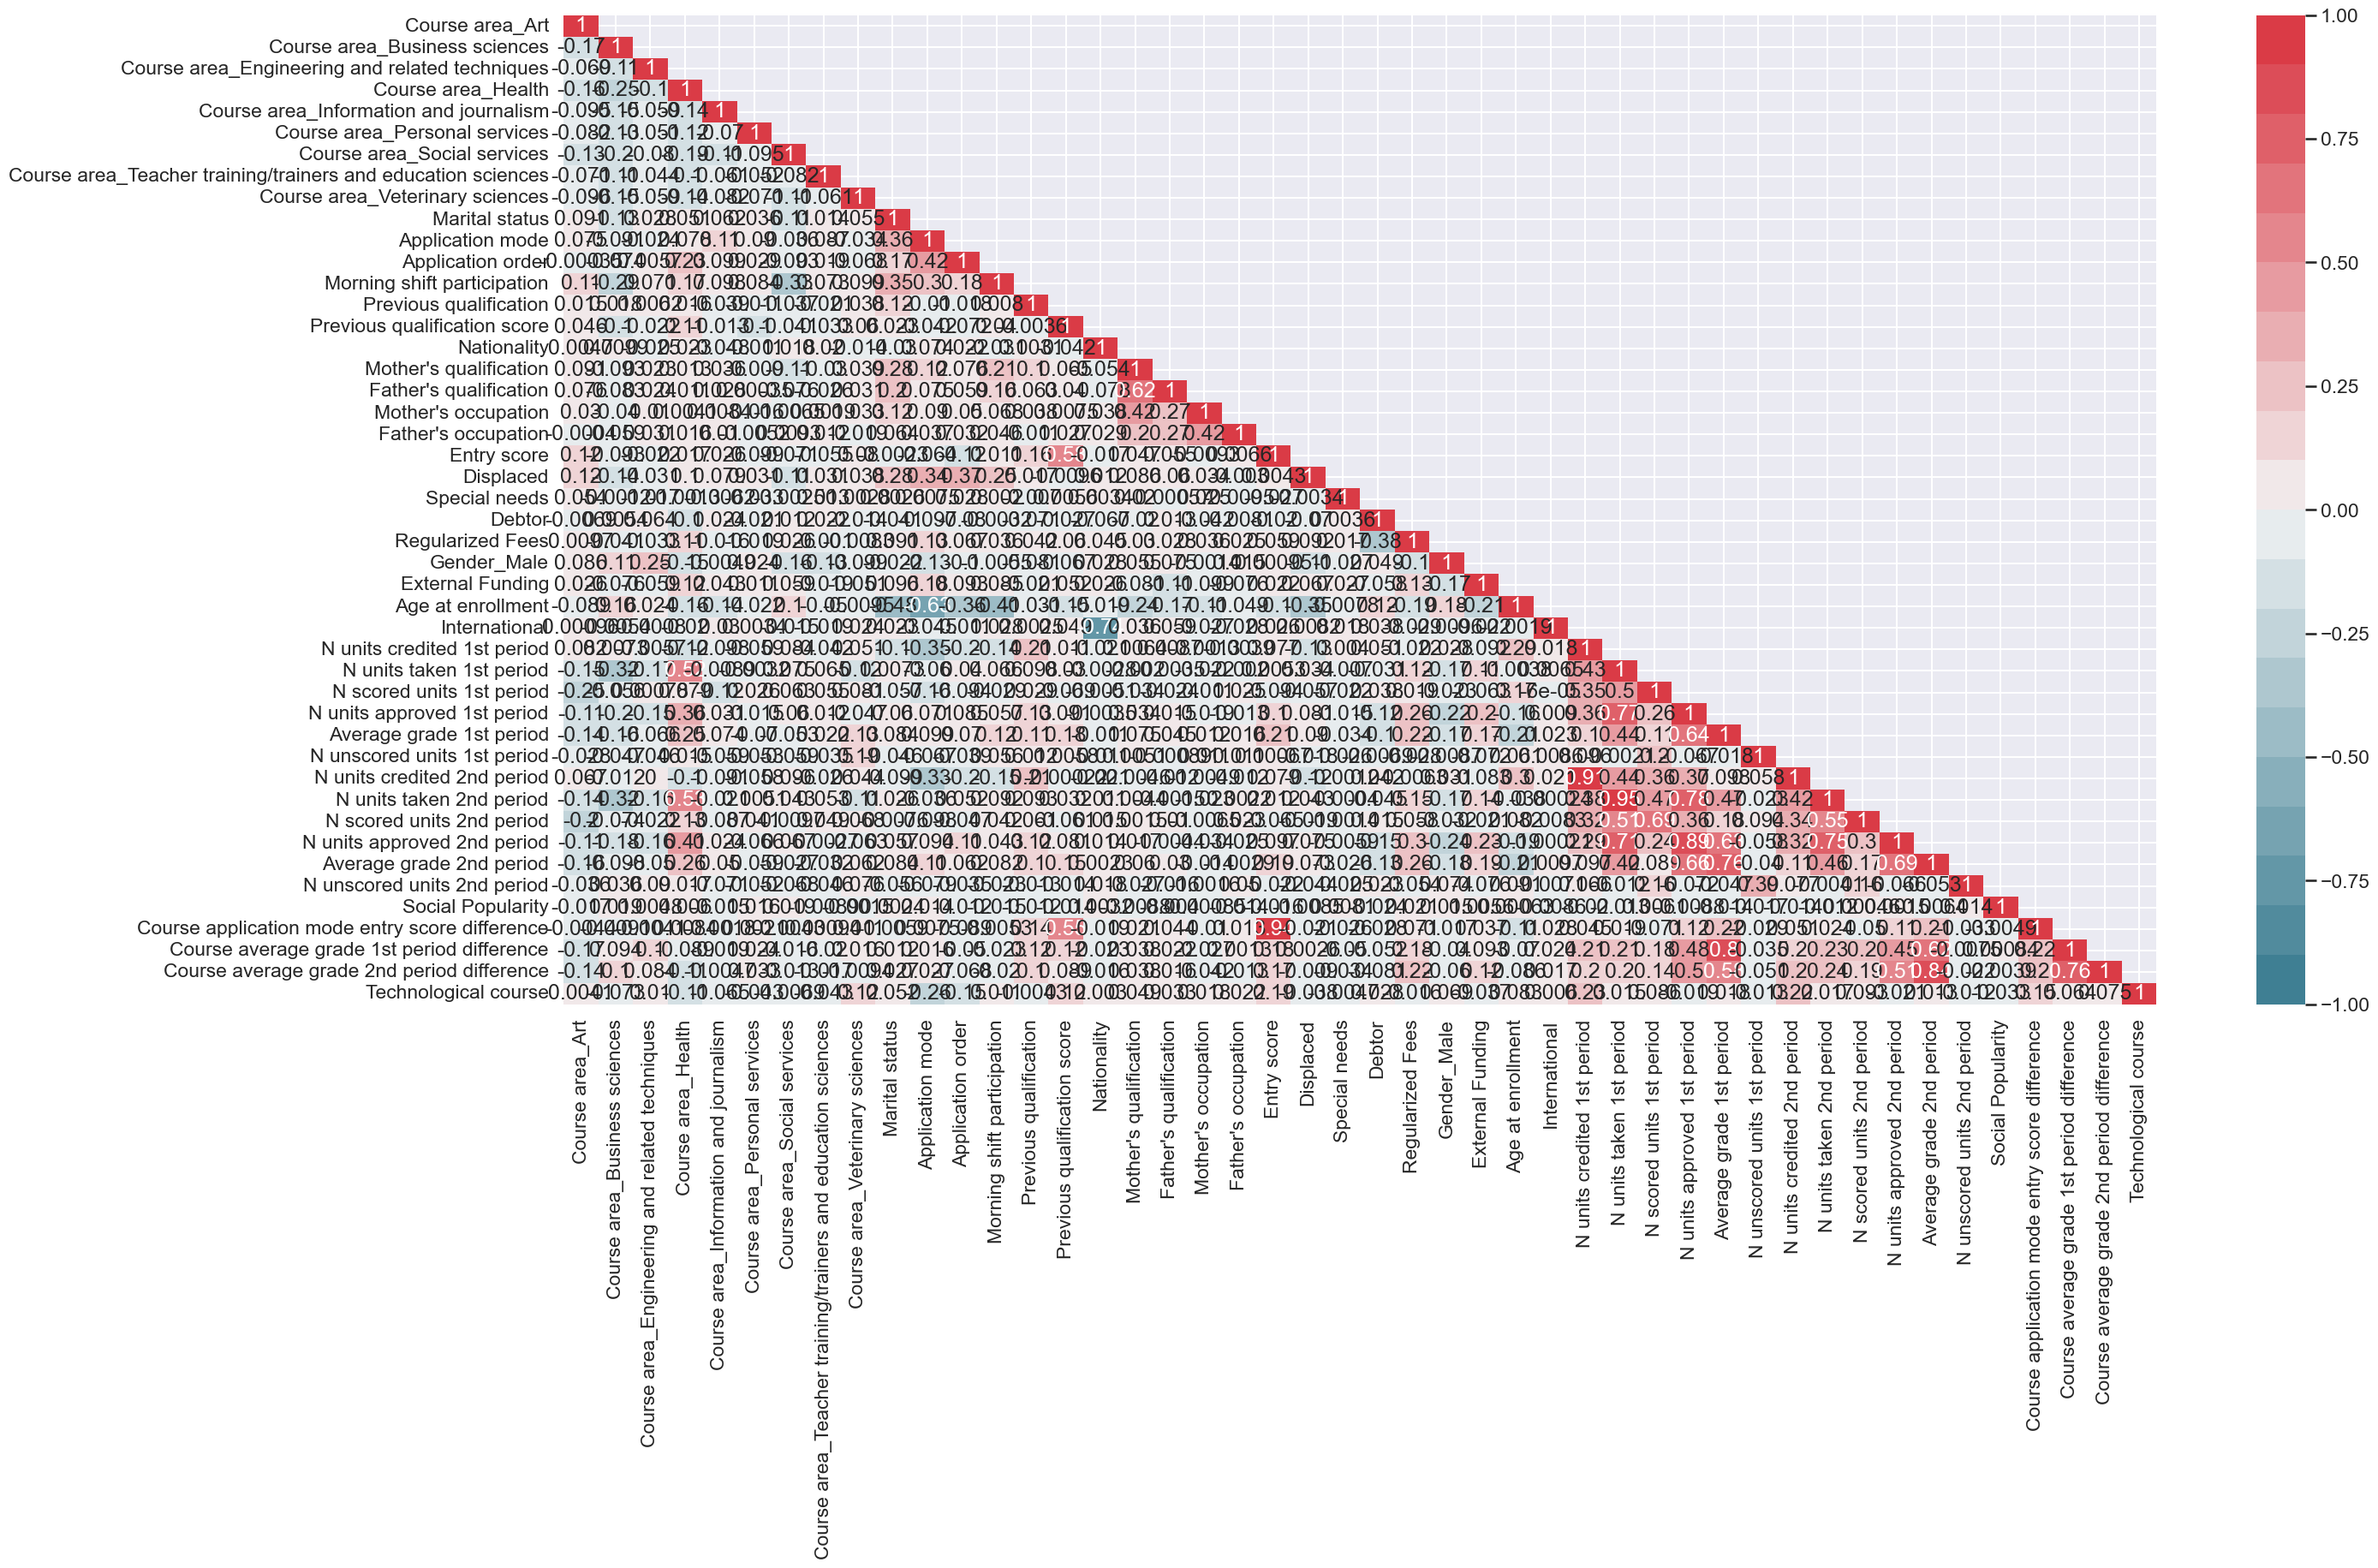

In [4]:
plot_correlation_matrix(data, 'spearman')

# Feature Engineering

In [5]:
data['N units credited'] = data['N units credited 1st period'] + data['N units credited 2nd period']
data['N units taken'] = data['N units taken 1st period'] + data['N units taken 2nd period']
data['N units approved'] = data['N units approved 1st period'] + data['N units approved 2nd period']
data['N scored units'] = data['N scored units 1st period'] + data['N scored units 2nd period']
data['N unscored units'] = data['N unscored units 1st period'] + data['N unscored units 2nd period']
data['Average grade'] = (data['Average grade 1st period'] * data['N units approved 1st period'] 
                         + data['Average grade 2nd period'] * data['N units approved 2nd period']
                         ) / (data['N units approved 1st period'] + data['N units approved 2nd period'])

data['Average grade'] = data['Average grade'].fillna(0)

periods_cols = list(data.columns[data.columns.str.contains(r'1st|2nd')])

data['Fail 1st period'] = (data['Average grade 1st period'] == 0).astype(bool)
data['Fail 2nd period'] = (data['Average grade 2nd period'] == 0).astype(bool)

data.drop(columns=['Nationality', 'Course application mode entry score difference'] + periods_cols, inplace=True)

In [6]:
# Demographic Traits
demographic_cols = [
    'Marital status', 
    # 'Nationality',
    'Mother\'s qualification', 
    'Father\'s qualification', 
    'Mother\'s occupation', 
    'Father\'s occupation', 
    'Gender_Male', 
    'Age at enrollment', 
    'International', 
    'Displaced', 
    'Special needs',
    'Social Popularity'
]

# Academic Performance
performance_cols = [
    'Previous qualification',
    'Previous qualification score',
    'Entry score',
    'N units credited',
    'N units taken',
    'N scored units',
    'N units approved',
    'Average grade',
    'N unscored units',
    'Fail 1st period',
    'Fail 2nd period'
]

# Financial Traits
financial_cols = [
    'Debtor',
    'Regularized Fees',
    'External Funding',
]

# Course/Program Details
course_cols = [
    'Course area_Art', 
    'Course area_Business sciences', 
    'Course area_Engineering and related techniques', 
    'Course area_Health', 
    'Course area_Information and journalism', 
    'Course area_Personal services', 
    'Course area_Social services', 
    'Course area_Teacher training/trainers and education sciences', 
    'Course area_Veterinary sciences', 
    'Application mode', 
    'Application order',
    'Morning shift participation',
    'Technological course'
]

# Data Preparation

## Scaling

In [7]:
data_no = data.copy()
data_mm = data_transform(MinMaxScaler(), data)[0]
data_rb = data_transform(RobustScaler(), data)[0]
data_yj = data_transform(PowerTransformer(), data)[0]

## Missing Values Imputation

In [8]:
# Get the optimal KNNImputer and impute the missing data
# Default values for n_neighbors and weights are 5 and 'uniform', respectively
print('NO SCALING')
data_no = apply_optimal_knnimputer(data_no, 2, 30, True)

print('\nMINMAX SCALER')
data_mm = apply_optimal_knnimputer(data_mm, 2, 30, True)

print('\nROBUST SCALER')
data_rb = apply_optimal_knnimputer(data_rb, 2, 30, True)

print('\nPOWER TRANSFORMER')
data_yj = apply_optimal_knnimputer(data_yj, 2, 30, True)

NO SCALING
KNNImputer(n_neighbors=2)

MINMAX SCALER
KNNImputer(n_neighbors=2, weights='distance')

ROBUST SCALER
KNNImputer(n_neighbors=2, weights='distance')

POWER TRANSFORMER
KNNImputer(n_neighbors=2, weights='distance')


In [9]:
# data_no = pd.read_csv(temp_path + 'imputed_data\\data_no.csv', index_col=0)
# data_mm = pd.read_csv(temp_path + 'imputed_data\\data_mm.csv', index_col=0)
# data_rb = pd.read_csv(temp_path + 'imputed_data\\data_rb.csv', index_col=0)
# data_yj = pd.read_csv(temp_path + 'imputed_data\\data_yj.csv', index_col=0)

# Clustering

In the notebook, the cluster analysis is grouped by data inputs - no scaling, principal components, standard scaler, minmax scaler, robust scaler. In each group, *n* methods of scaling were used and they are presented in this order:
1. KMeans
2. Single (Hierarchical)
3. Complete (Hierarchical)
4. Ward (Hierarchical)
5. Average (Hierarchical)
6. Meanshift [*if applied*]

In each application, it was chosen the best solution (from our perspective). In the situations that solutions of different number of clusters were compared the sacrificed ones were put as comment as well as the cluster comparision between them, in case that one would like to see the differences.

## No scaling

### KMeans

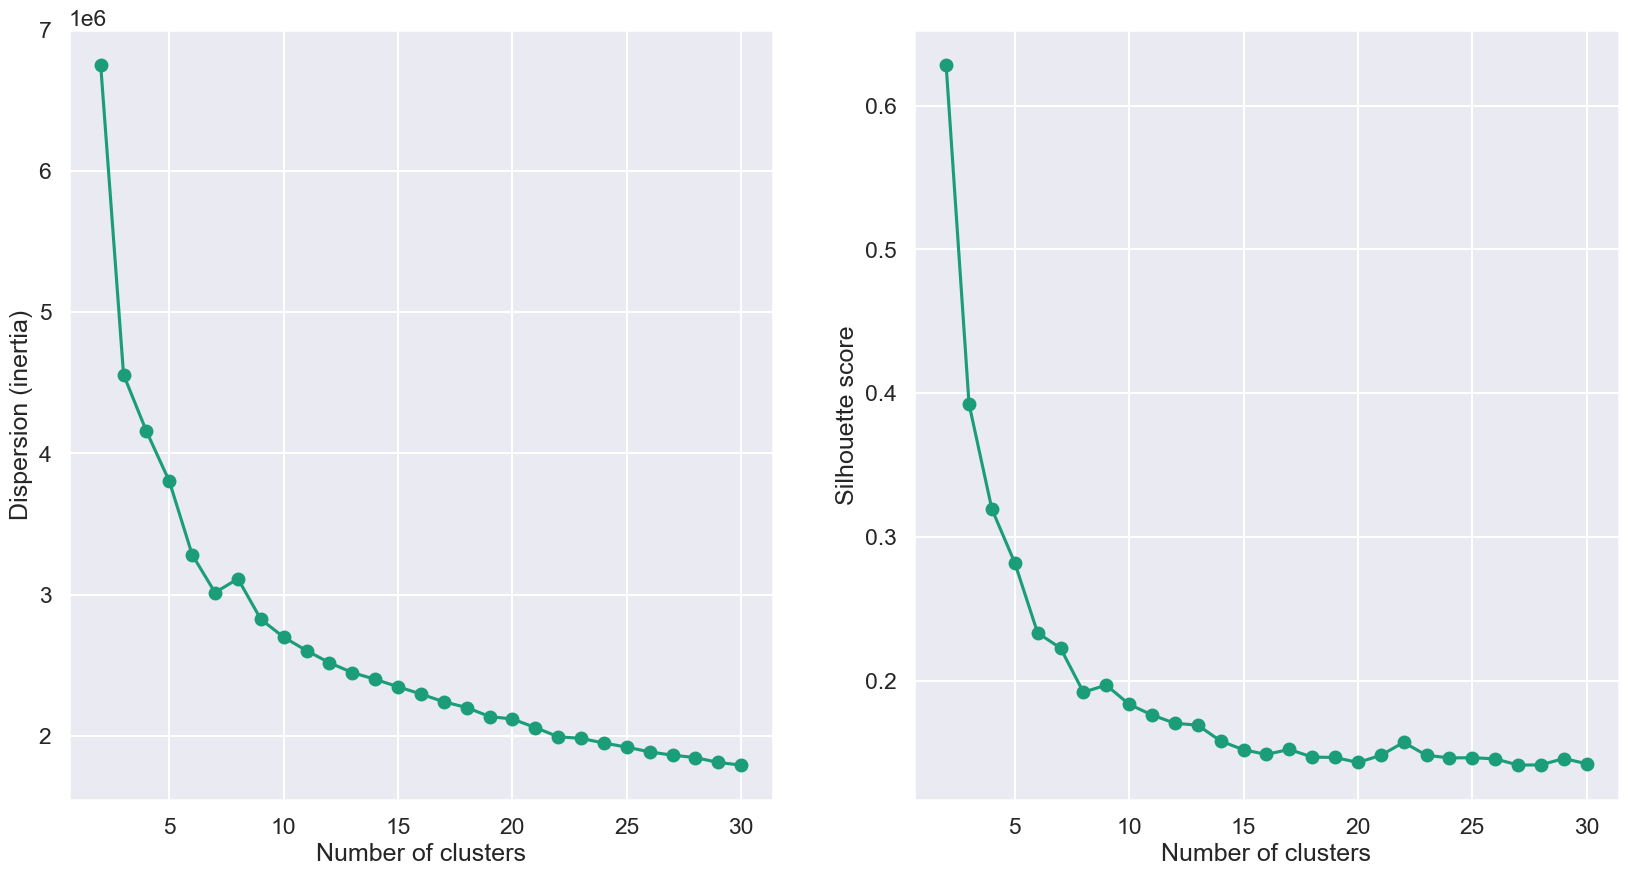

In [10]:
plot_inertia_and_silhouette(data_no)

---

### Hierarchical Clustering

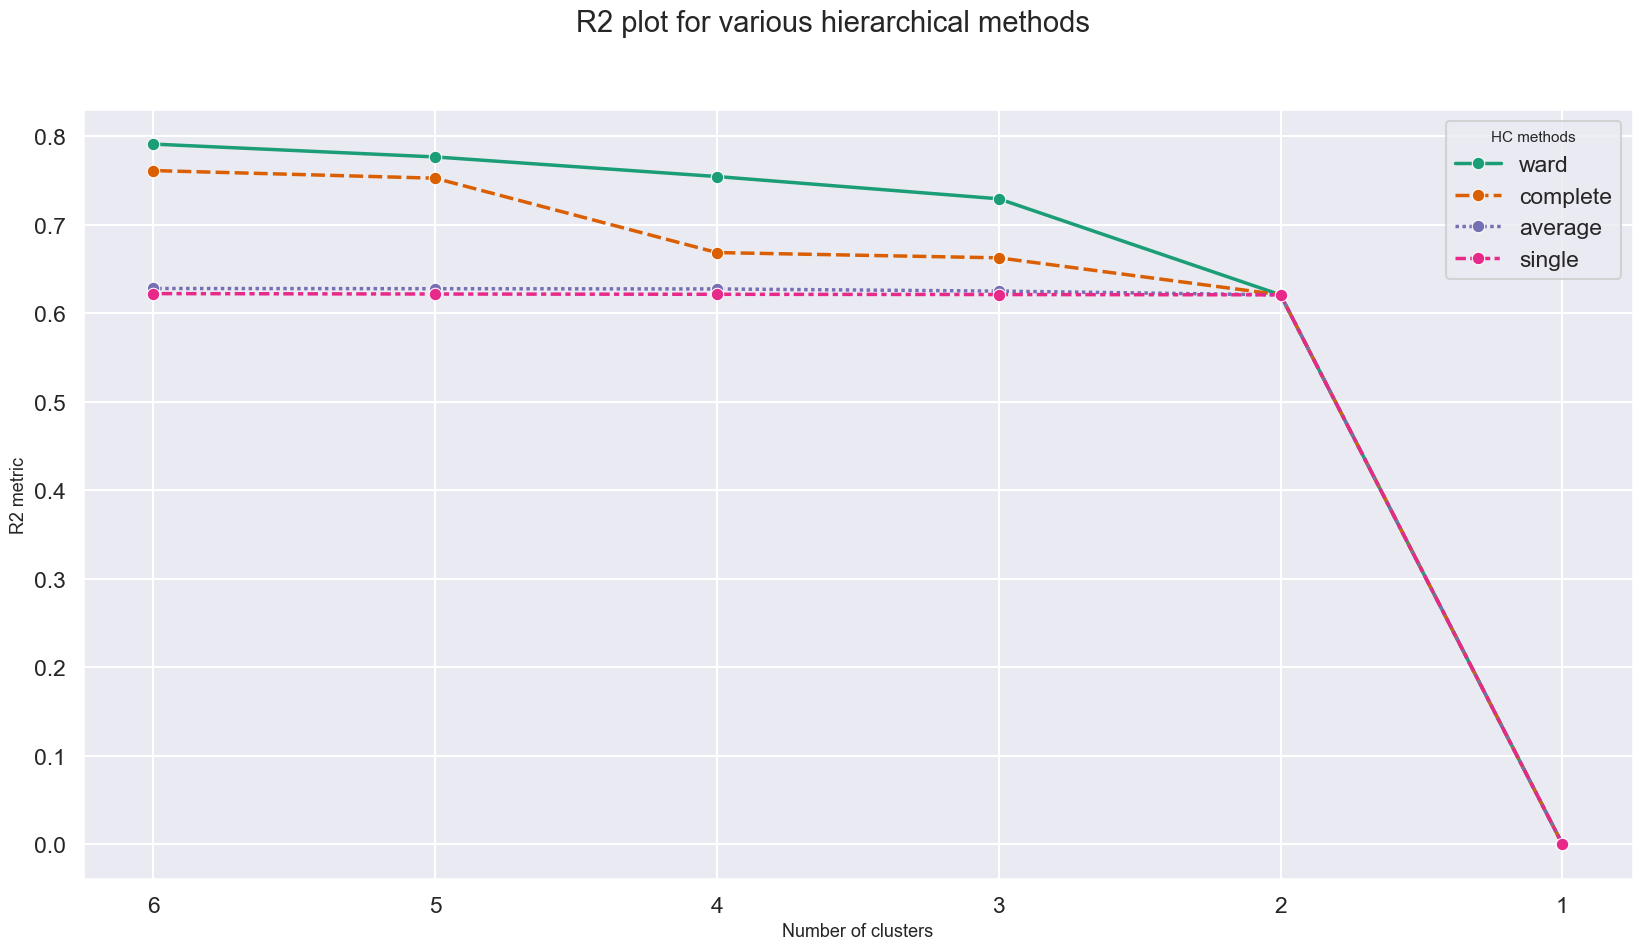

In [11]:
plot_r2_hc(data_no)

#### Single

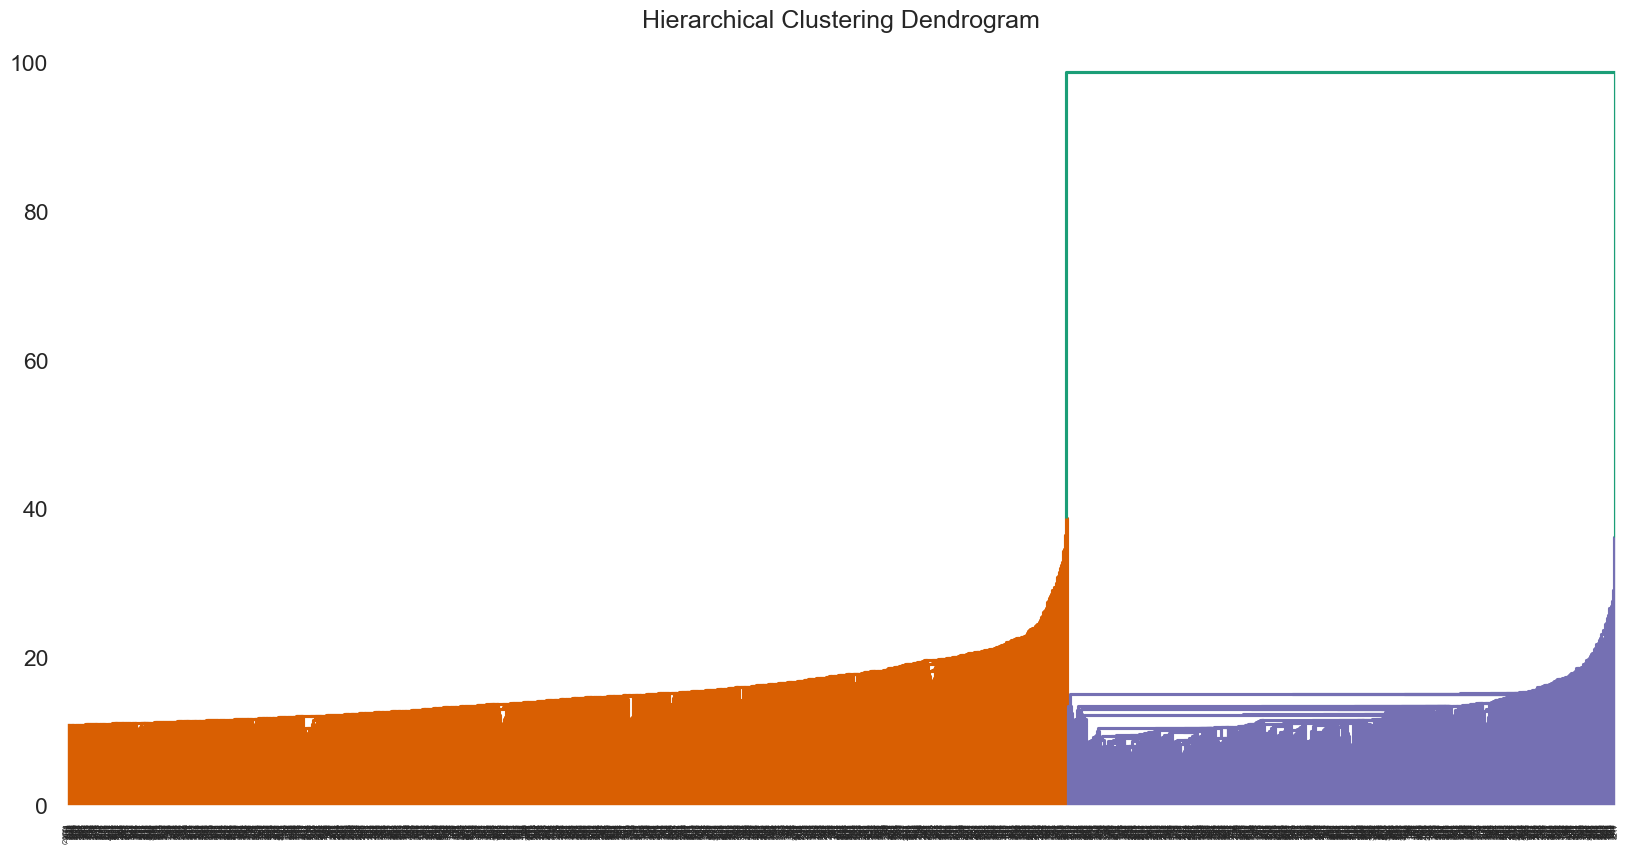

In [12]:
plot_dendrogram(data_no, 'single')

In [13]:
data['no_single2'] = AgglomerativeClustering(
    linkage='single', n_clusters=2
    ).fit_predict(data_no)

In [14]:
groupby_mean(data, 'no_single2')

no_single2                                                   0           1
Course area_Art                                       0.065163    0.248499
Course area_Business sciences                         0.209691    0.195678
Course area_Engineering and related techniques        0.034252    0.070828
Course area_Health                                    0.211640    0.110444
Course area_Information and journalism                0.080479    0.050420
Course area_Personal services                         0.058480    0.050420
Course area_Social services                           0.135895    0.098439
Course area_Teacher training/trainers and educa...    0.045391    0.034814
Course area_Veterinary sciences                       0.082428    0.049220
Marital status                                        0.893344    0.853541
Application mode                                      0.907723    0.726044
Application order                                     1.748440    1.634568
Morning shift participation                           0.897522    0.881152
Previous qualification                               12.064067   11.978365
Previous qualification score                        132.532303  132.962545
Mother's qualification                                9.113708    9.182864
Father's qualification                                8.367330    8.511450
Mother's occupation                                   0.635199    0.668667
Father's occupation                                   0.766360    0.769508
Entry score                                         127.031106  126.749700
Displaced                                             0.565302    0.521008
Special needs                                         0.029797    0.036014
Debtor                                                0.117238    0.194478
Regularized Fees                                      0.915065    0.738295
Gender_Male                                           0.331106    0.510204
External Funding                                      0.291005    0.140456
Age at enrollment                                    22.808631   25.275184
International                                         0.046784    0.036014
Social Popularity                                    49.585631   48.685474
Technological course                                  0.051518    0.040816
N units credited                                      1.448306    0.293893
N units taken                                        13.180475    6.666667
N units approved                                     10.770259    0.000000
N scored units                                       18.083647    8.775126
N unscored units                                      0.254134    0.450125
Average grade                                       126.890555    0.000000
Fail 1st period                                       0.010582    0.816327
Fail 2nd period                                       0.050961    0.824730

---

#### Complete

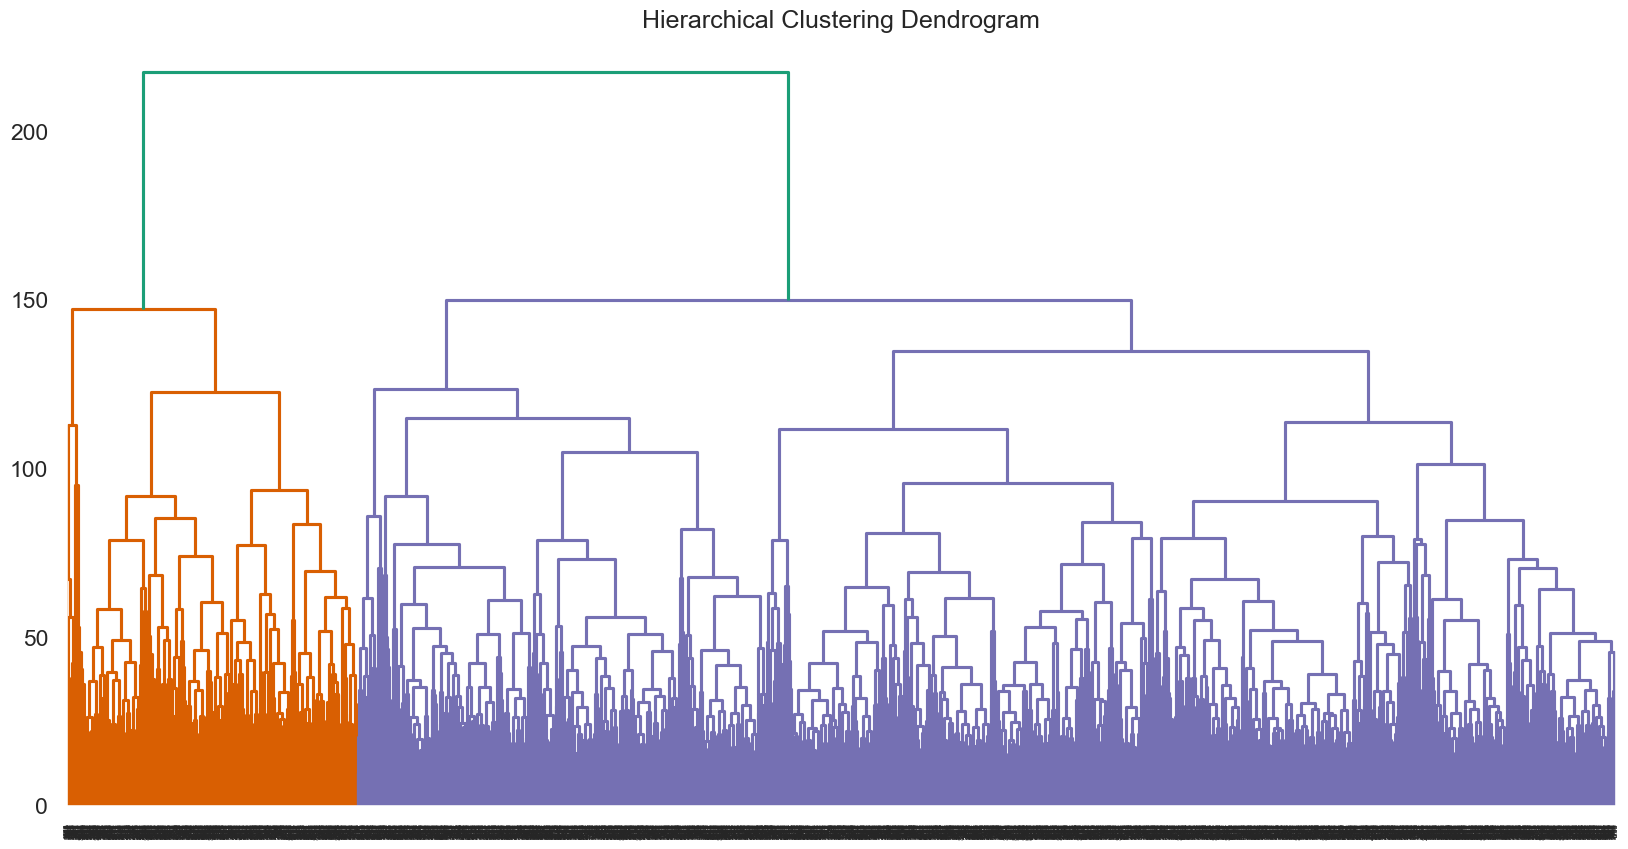

In [15]:
plot_dendrogram(data_no, 'complete')

In [16]:
data['no_complete2'] = AgglomerativeClustering(
    linkage='complete', n_clusters=2
    ).fit_predict(data_no)

In [17]:
clusters_comparison(data, 'no_single2', 'no_complete2')

no_complete2 0 Cluster  no_complete2 1 Cluster
no_single2 0 Cluster                    3591                       0
no_single2 1 Cluster                       0                     833

---

#### Ward

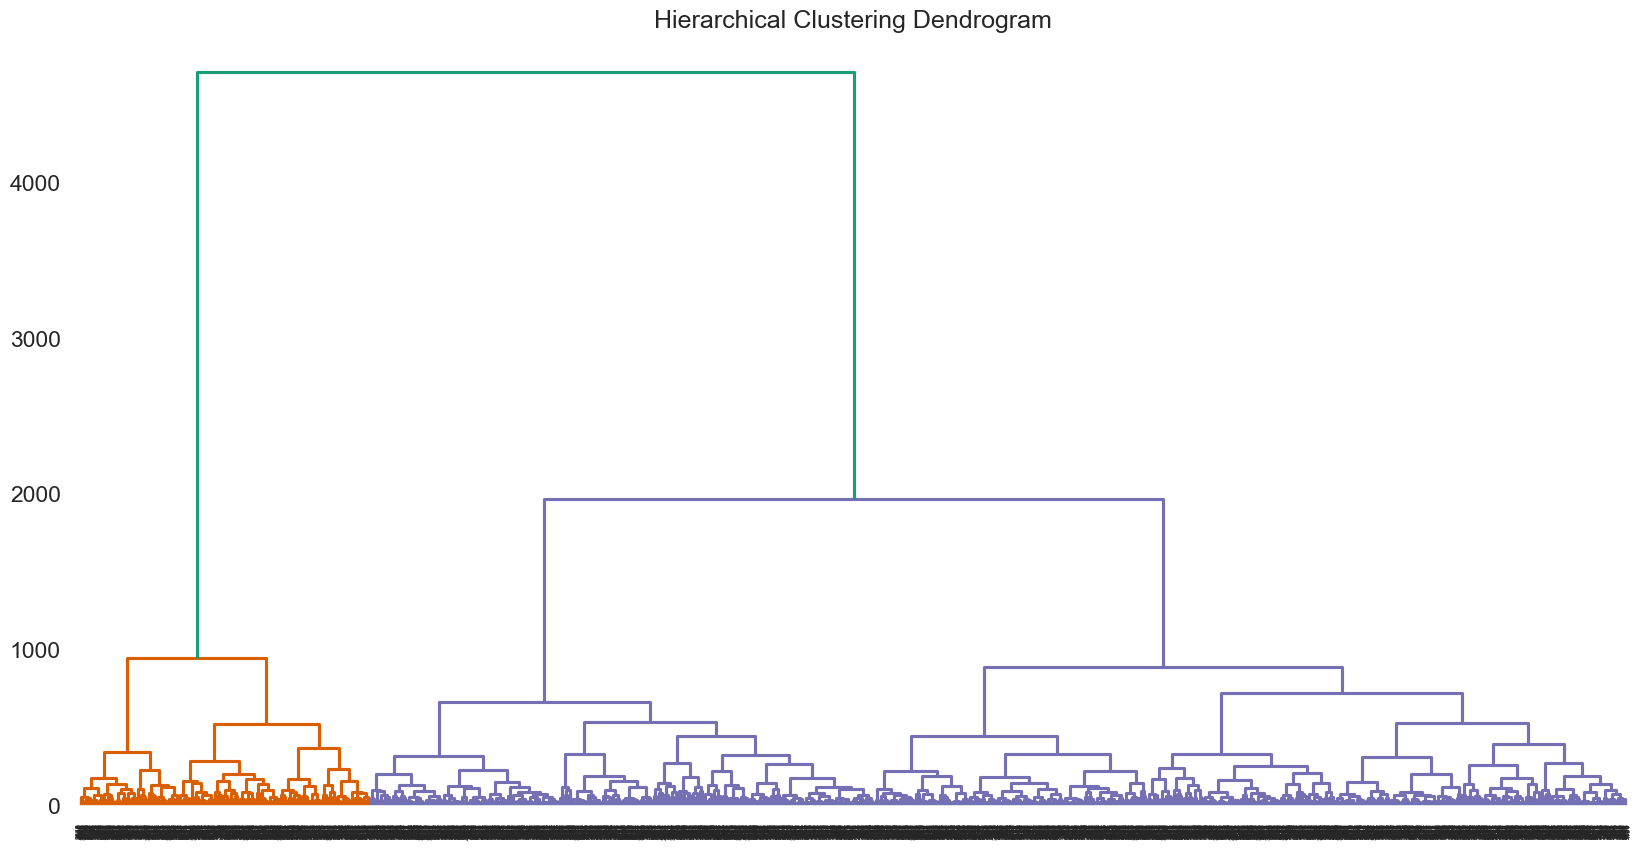

In [18]:
plot_dendrogram(data_no, 'ward')

In [19]:
data['no_ward2'] = AgglomerativeClustering(
    linkage='ward', n_clusters=2
    ).fit_predict(data_no)

data['no_ward3'] = AgglomerativeClustering(
    linkage='ward', n_clusters=3
    ).fit_predict(data_no)

In [20]:
# clusters_comparison(people, 'no_ward4', 'no_ward5')
# clusters_comparison(people, 'no_ward5', 'no_ward6')

In [21]:
clusters_comparison(data, 'no_single2', 'no_ward2')

no_ward2 0 Cluster  no_ward2 1 Cluster
no_single2 0 Cluster                3591                   0
no_single2 1 Cluster                   0                 833

In [22]:
clusters_comparison(data, 'no_ward3', 'no_ward2')

no_ward2 0 Cluster  no_ward2 1 Cluster
no_ward3 0 Cluster                   0                 833
no_ward3 1 Cluster                2148                   0
no_ward3 2 Cluster                1443                   0

---

#### Average

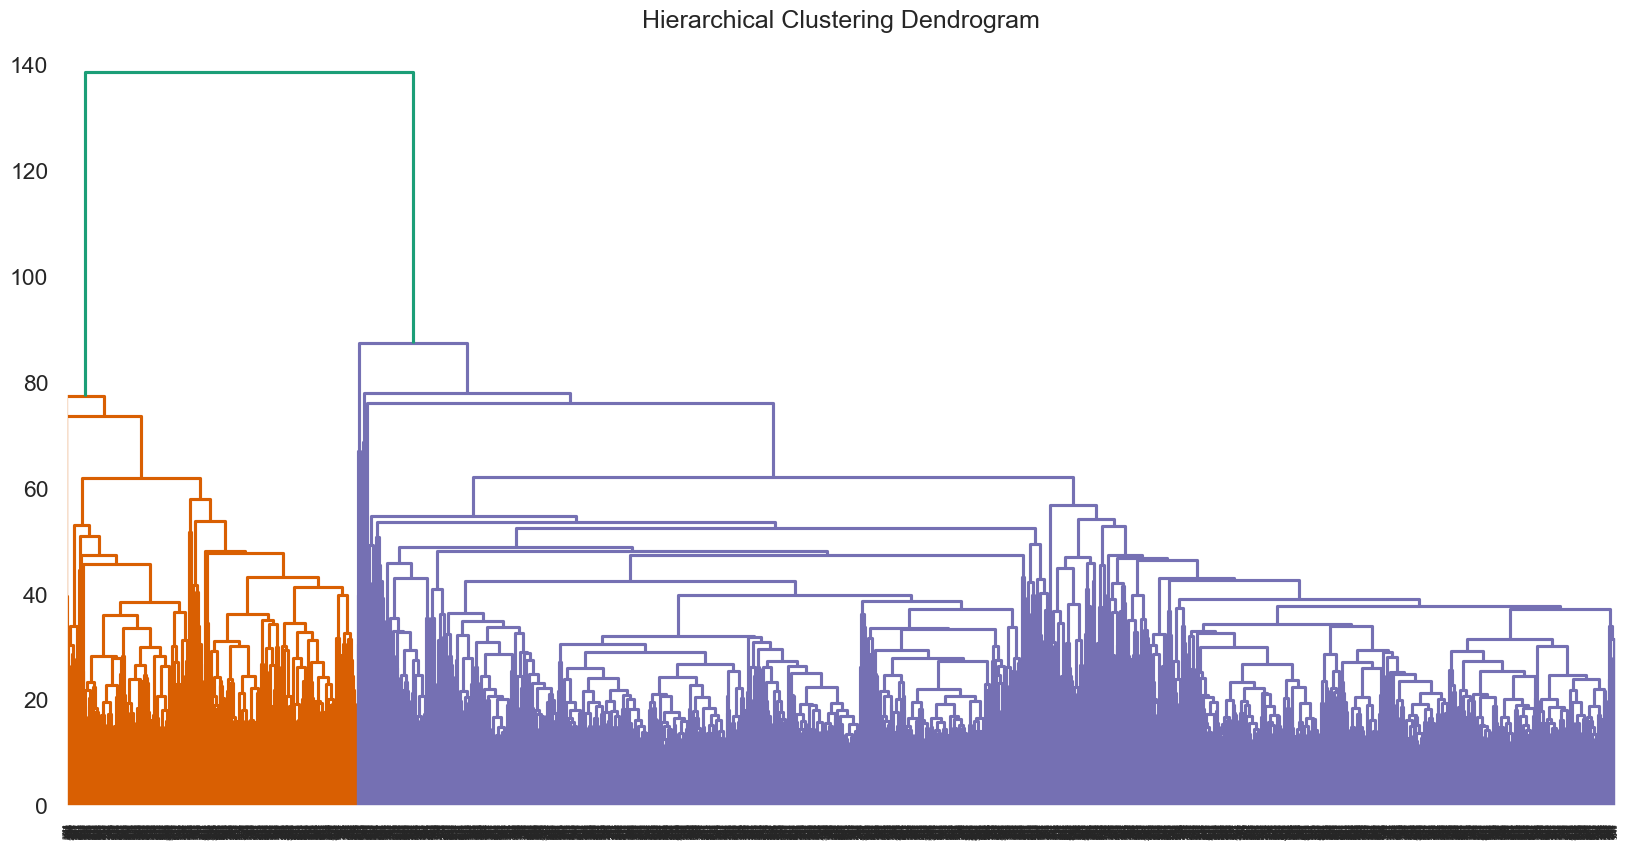

In [23]:
plot_dendrogram(data_no, 'average')

In [24]:
data['no_average2'] = AgglomerativeClustering(
    linkage='average', n_clusters=2
    ).fit_predict(data_no)

In [25]:
clusters_comparison(data, 'no_single2', 'no_average2')

no_average2 0 Cluster  no_average2 1 Cluster
no_single2 0 Cluster                   3591                      0
no_single2 1 Cluster                      0                    833

### MeanShift

In [26]:
no_meanshift = MeanShift(bandwidth=40, bin_seeding=True, n_jobs=-1).fit(data_no)
data['no_meanshift'] = no_meanshift.labels_

In [27]:
clusters_comparison(data, 'no_single2', 'no_meanshift')

no_meanshift 0 Cluster  no_meanshift 1 Cluster
no_single2 0 Cluster                    3591                       0
no_single2 1 Cluster                       0                     833

### UMAP

c:\Users\Afonso Cadete\anaconda3\envs\ml\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
g:\O meu disco\Universidade\3rd year\2nd semester\Machine Learning\II\Project\utils2.py:387: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=cmap(norm(i)), label=label) for i, label in enumerate(labels)]


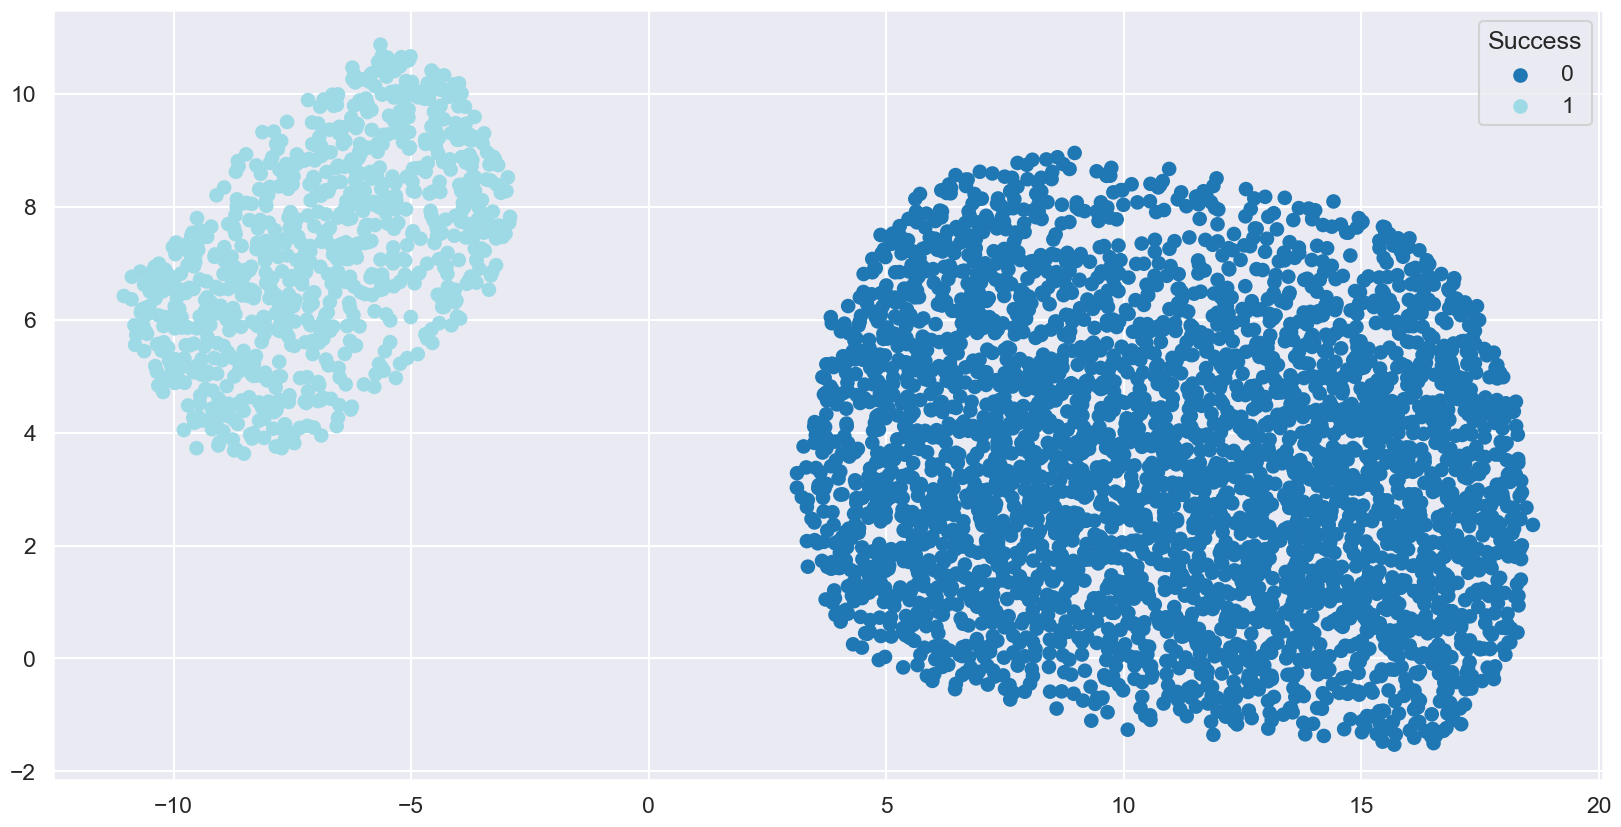

In [28]:
umap_object = umap.UMAP(n_neighbors=160, min_dist=1, random_state=16, n_jobs=-1)
umap_embedding = umap_object.fit_transform(data_no)
visualize_dimensionality_reduction(umap_embedding, data['no_single2'])

---
---

## MinMax

### KMeans

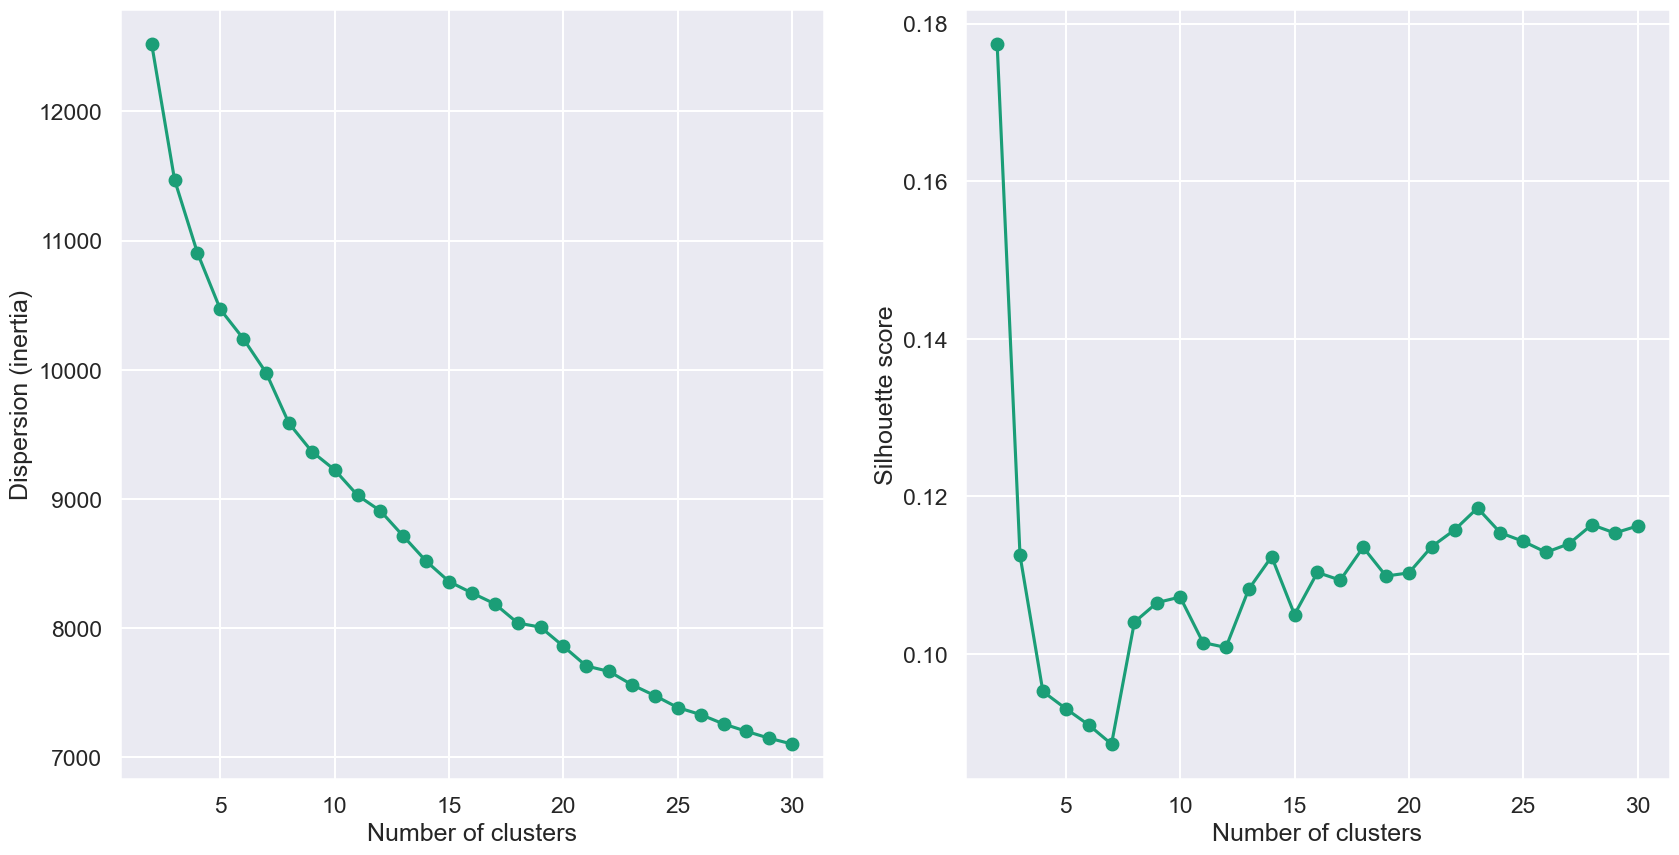

In [29]:
plot_inertia_and_silhouette(data_mm)

### Hierarchical

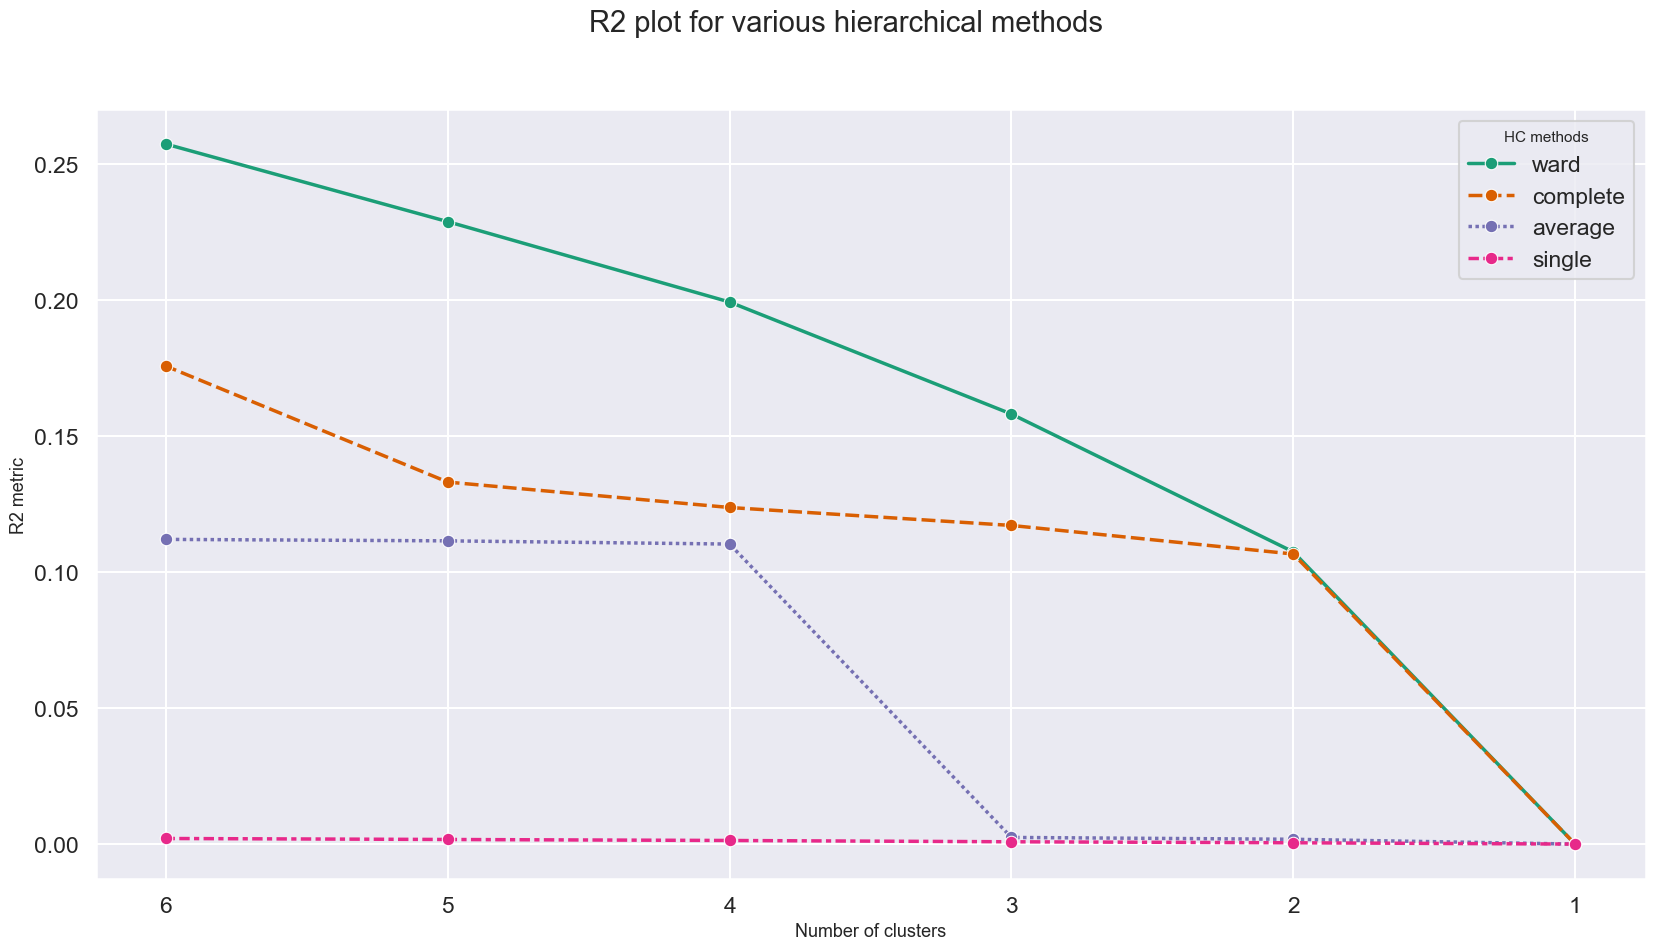

In [30]:
plot_r2_hc(data_mm)

## Robust

### KMeans

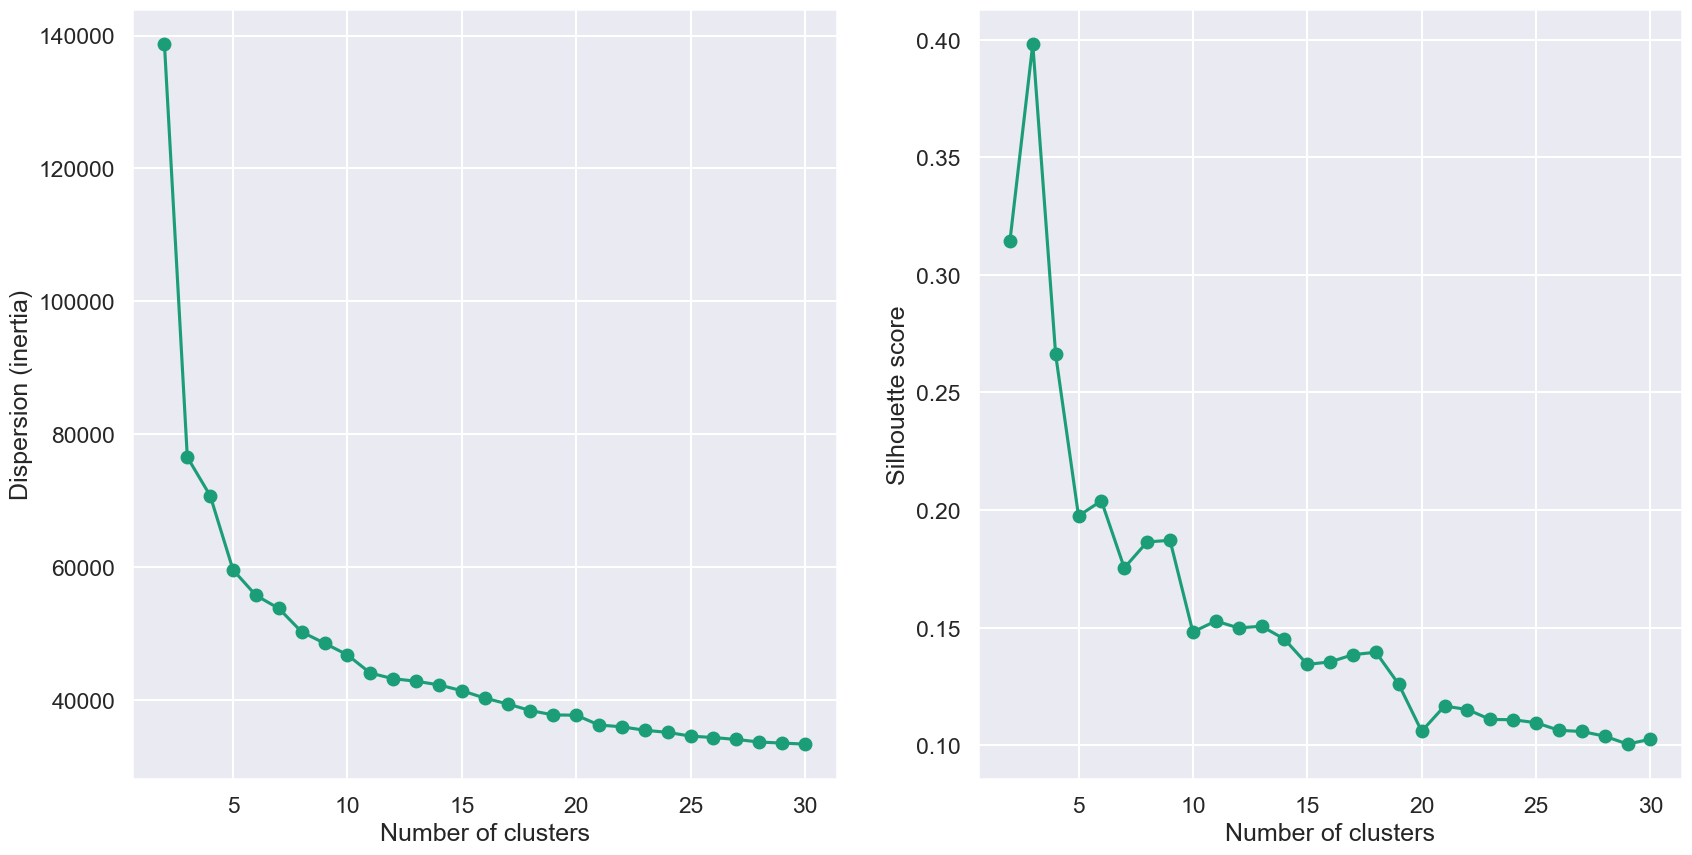

In [31]:
plot_inertia_and_silhouette(data_rb)

---

### Hierarchical Clustering

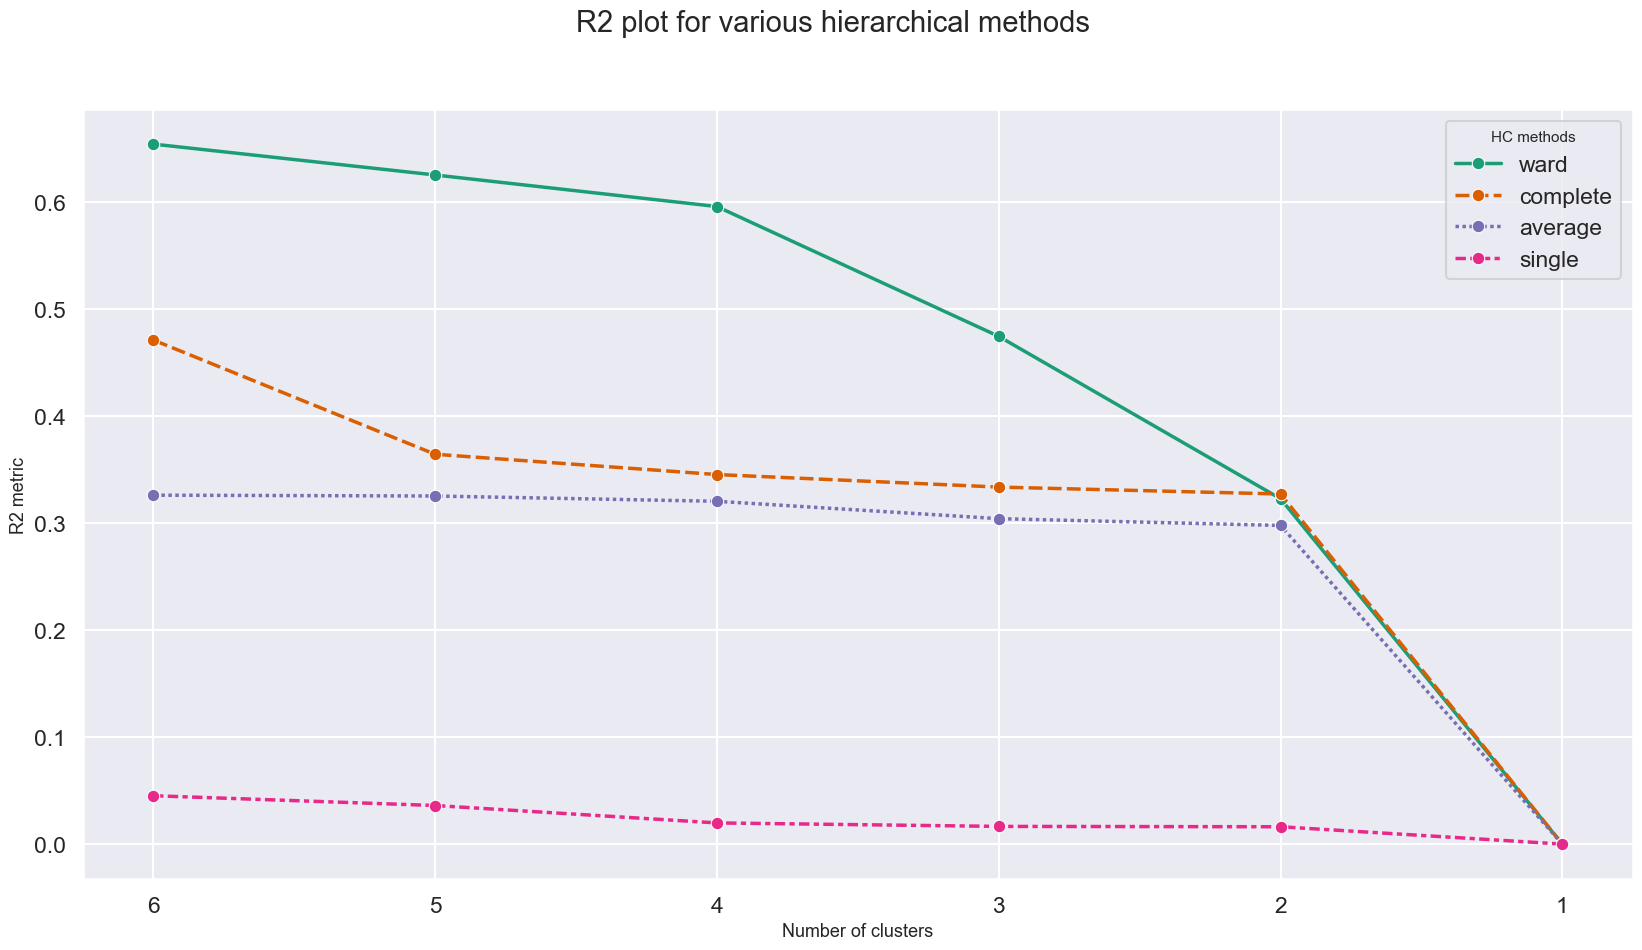

In [32]:
plot_r2_hc(data_rb)

#### Single

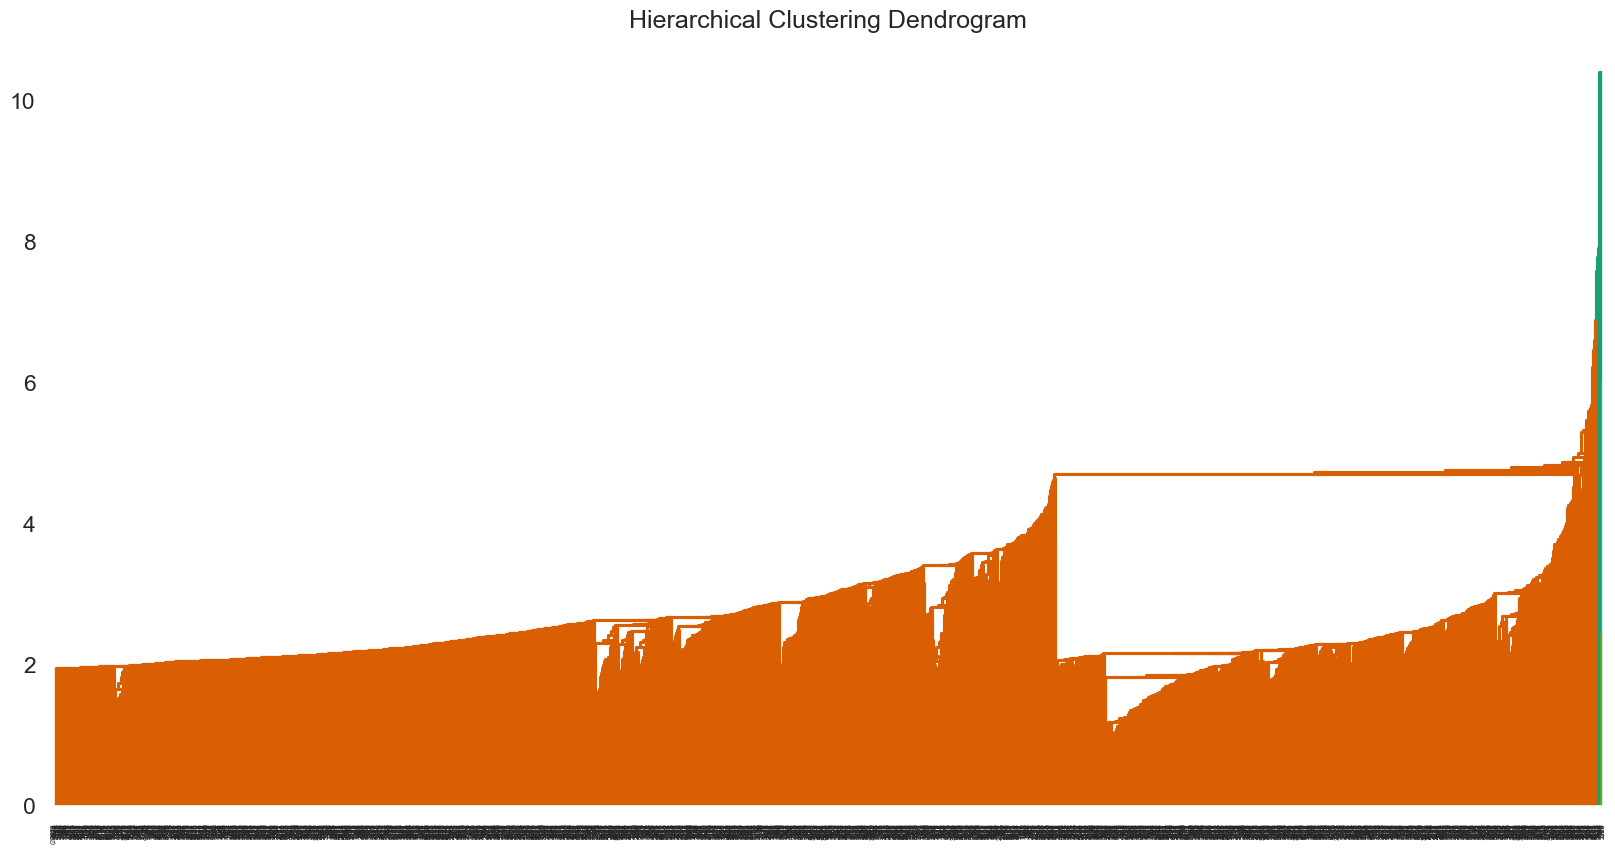

In [33]:
plot_dendrogram(data_rb, 'single')

---

#### Complete

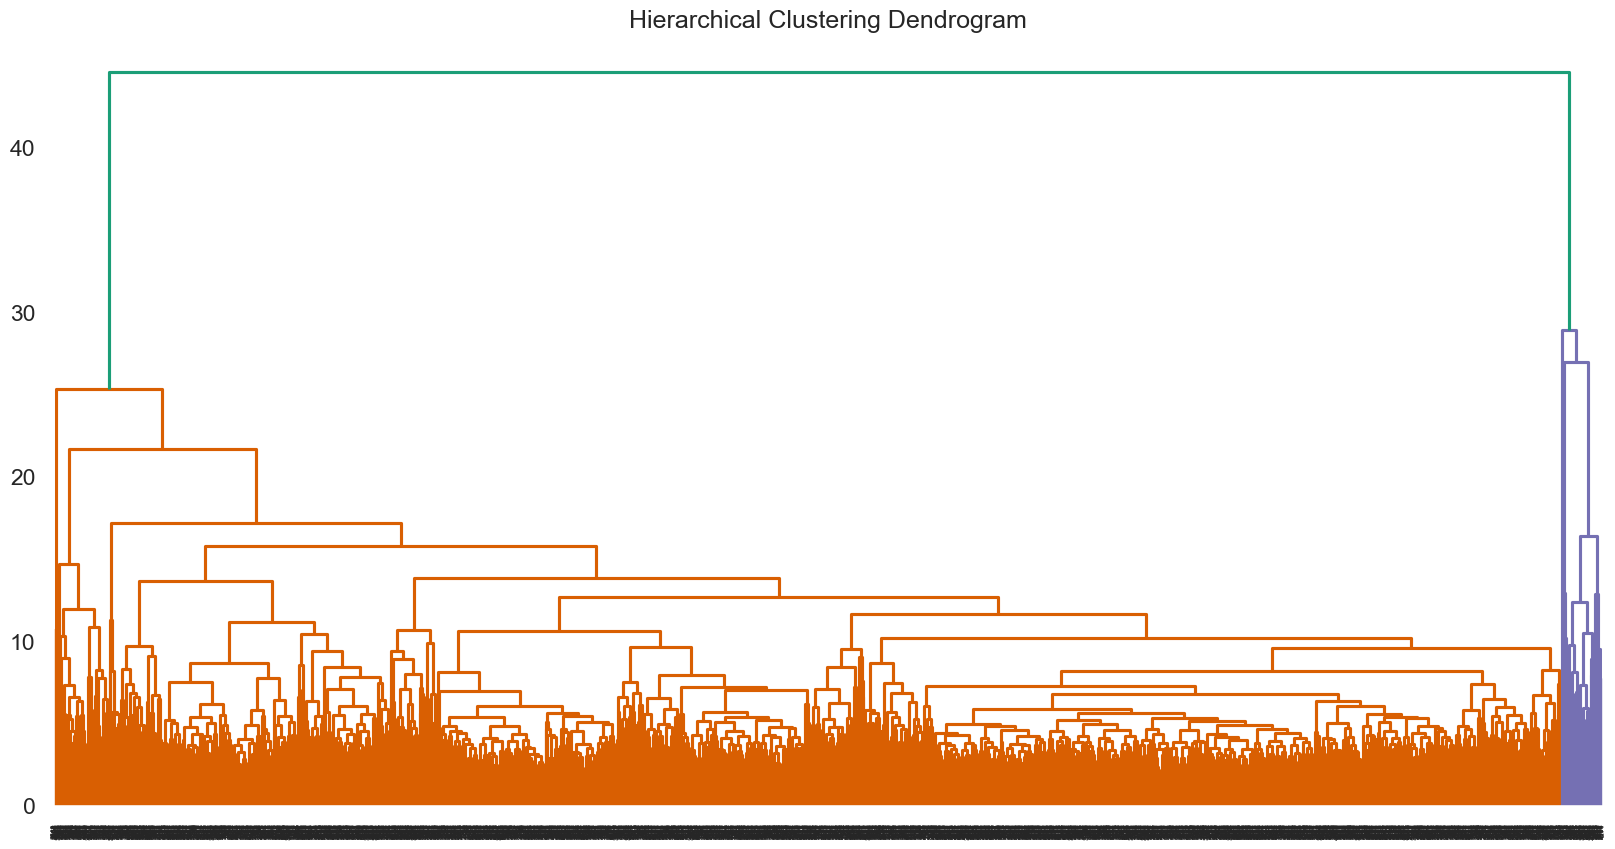

In [34]:
plot_dendrogram(data_rb, 'complete')

In [41]:
data['rb_complete2'] = AgglomerativeClustering(
    linkage='complete', n_clusters=2
    ).fit_predict(data_rb)

In [36]:
clusters_comparison(data, 'no_single2', 'rb_complete2')

rb_complete2 0 Cluster  rb_complete2 1 Cluster
no_single2 0 Cluster                     112                    3479
no_single2 1 Cluster                       5                     828

In [42]:
groupby_mean(data, 'rb_complete2')

rb_complete2                                                 0           1
Course area_Art                                       0.162393    0.097980
Course area_Business sciences                         0.247863    0.205944
Course area_Engineering and related techniques        0.025641    0.041560
Course area_Health                                    0.076923    0.195728
Course area_Information and journalism                0.008547    0.076619
Course area_Personal services                         0.025641    0.057813
Course area_Social services                           0.170940    0.127699
Course area_Teacher training/trainers and educa...    0.068376    0.042721
Course area_Veterinary sciences                       0.017094    0.077780
Marital status                                        0.769231    0.889018
Application mode                                      0.241379    0.890995
Application order                                     1.130435    1.743426
Morning shift participation                           0.777778    0.897609
Previous qualification                               12.615385   12.032520
Previous qualification score                        130.894017  132.660019
Mother's qualification                                7.990566    9.155078
Father's qualification                                7.342857    8.419900
Mother's occupation                                   0.572650    0.643371
Father's occupation                                   0.717949    0.768284
Entry score                                         127.568376  126.962085
Displaced                                             0.401709    0.561179
Special needs                                         0.017094    0.031344
Debtor                                                0.119658    0.132111
Regularized Fees                                      0.914530    0.880892
Gender_Male                                           0.384615    0.364291
External Funding                                      0.094017    0.267239
Age at enrollment                                    30.373913   23.078181
International                                         0.051282    0.044579
Social Popularity                                    50.290598   49.392384
Technological course                                  0.042735    0.049687
N units credited                                     21.798246    0.665939
N units taken                                        29.142857   11.492267
N units approved                                     25.910714    8.668282
N scored units                                       36.065421   15.831322
N unscored units                                      1.052174    0.269956
Average grade                                       118.999216  102.563518
Fail 1st period                                       0.000000    0.166705
Fail 2nd period                                       0.000000    0.201997
no_single2                                            0.042735    0.192245
no_complete2                                          0.042735    0.192245
no_ward2                                              0.042735    0.192245
no_ward3                                              1.623932    1.124681
no_average2                                           0.042735    0.192245
no_meanshift                                          0.042735    0.192245
rb_ward2                                              1.000000    0.087068
rb_ward4                                              2.589744    0.467843

---

#### Ward

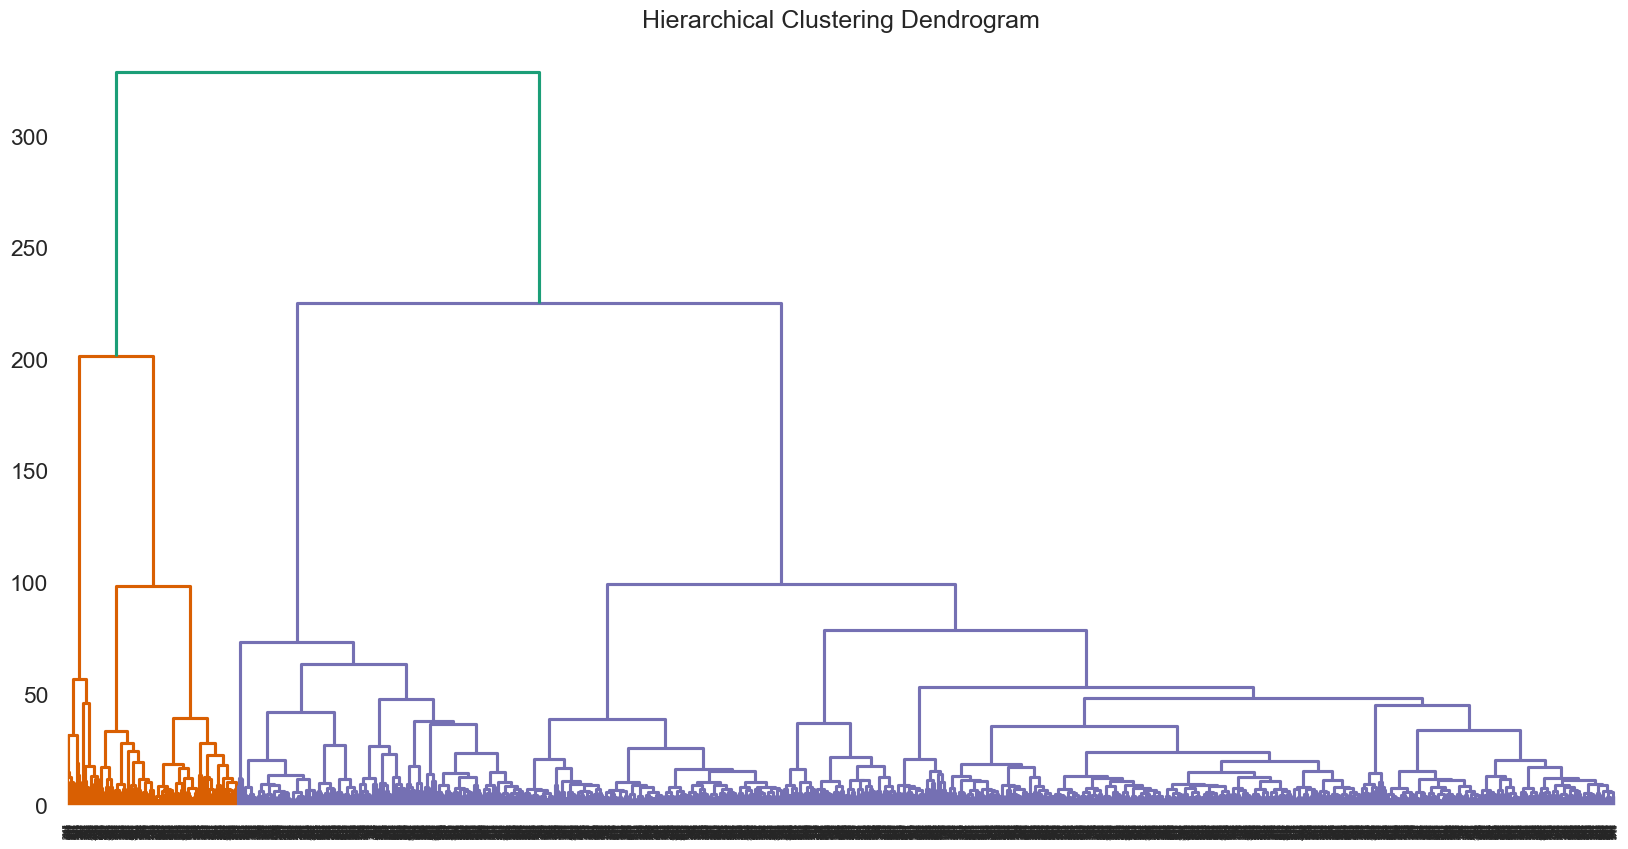

In [37]:
plot_dendrogram(data_rb, 'ward')

In [38]:
data['rb_ward2'] = AgglomerativeClustering(
    linkage='ward', n_clusters=2
    ).fit_predict(data_rb)

data['rb_ward4'] = AgglomerativeClustering(
    linkage='ward', n_clusters=4
    ).fit_predict(data_rb)

In [39]:
clusters_comparison(data, 'rb_complete2', 'rb_ward2')

rb_ward2 0 Cluster  rb_ward2 1 Cluster
rb_complete2 0 Cluster                   0                 117
rb_complete2 1 Cluster                3932                 375

In [40]:
clusters_comparison(data, 'no_single2', 'rb_ward2')

rb_ward2 0 Cluster  rb_ward2 1 Cluster
no_single2 0 Cluster                3116                 475
no_single2 1 Cluster                 816                  17

In [39]:
groupby_mean(data, 'no_complete2')

no_complete2                                                 0           1
Course area_Art                                       0.065163    0.248499
Course area_Business sciences                         0.209691    0.195678
Course area_Engineering and related techniques        0.034252    0.070828
Course area_Health                                    0.211640    0.110444
Course area_Information and journalism                0.080479    0.050420
Course area_Personal services                         0.058480    0.050420
Course area_Social services                           0.135895    0.098439
Course area_Teacher training/trainers and educa...    0.045391    0.034814
Course area_Veterinary sciences                       0.082428    0.049220
Marital status                                        0.893344    0.853541
Application mode                                      0.907723    0.726044
Application order                                     1.748440    1.634568
Morning shift participation                           0.897522    0.881152
Previous qualification                               12.064067   11.978365
Previous qualification score                        132.532303  132.962545
Mother's qualification                                9.113708    9.182864
Father's qualification                                8.367330    8.511450
Mother's occupation                                   0.635199    0.668667
Father's occupation                                   0.766360    0.769508
Entry score                                         127.031106  126.749700
Displaced                                             0.565302    0.521008
Special needs                                         0.029797    0.036014
Debtor                                                0.117238    0.194478
Regularized Fees                                      0.915065    0.738295
Gender_Male                                           0.331106    0.510204
External Funding                                      0.291005    0.140456
Age at enrollment                                    22.808631   25.275184
International                                         0.046784    0.036014
Social Popularity                                    49.585631   48.685474
Technological course                                  0.051518    0.040816
N units credited                                      1.448306    0.293893
N units taken                                        13.180475    6.666667
N units approved                                     10.770259    0.000000
N scored units                                       18.083647    8.775126
N unscored units                                      0.254134    0.450125
Average grade                                       126.890555    0.000000
Fail 1st period                                       0.010582    0.816327
Fail 2nd period                                       0.050961    0.824730
no_single2                                            0.000000    1.000000
no_ward2                                              0.000000    1.000000
no_ward3                                              1.401838    0.000000
no_average2                                           0.000000    1.000000
no_meanshift                                          0.000000    1.000000
rb_complete2                                          0.968811    0.993998
rb_ward2                                              0.132275    0.020408
rb_ward4                                              0.183514    1.991597

---

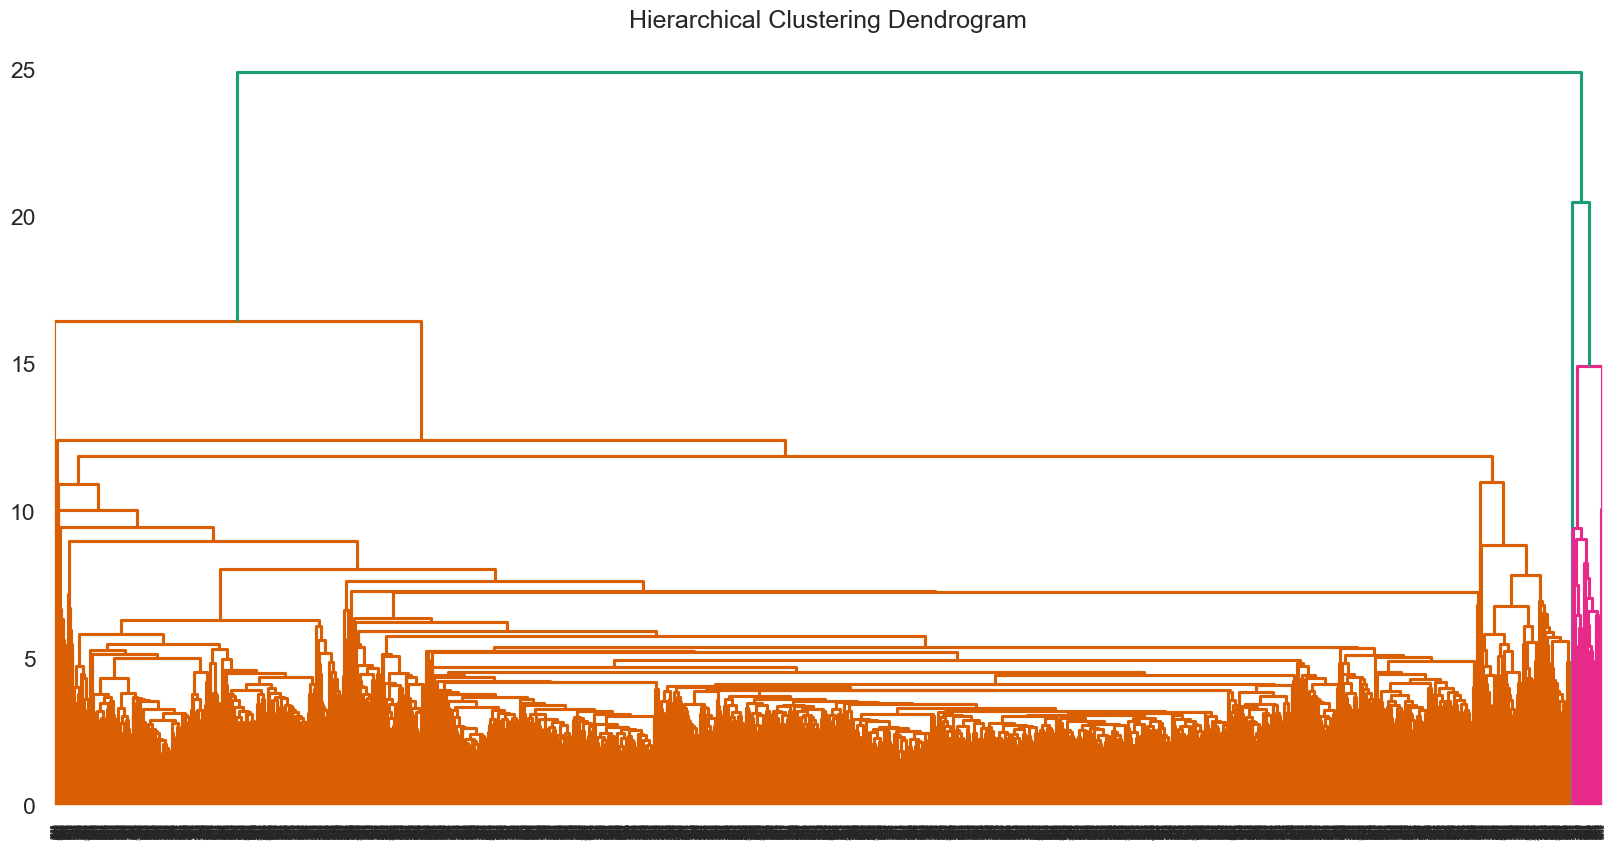

In [41]:
plot_dendrogram(data_rb, 'average')

In [43]:
data['rb_average2'] = AgglomerativeClustering(
    linkage='average', n_clusters=2
    ).fit_predict(data_rb)

In [43]:
clusters_comparison(data, 'rb_ward2', 'rb_average2')

rb_average2 0 Cluster  rb_average2 1 Cluster
rb_ward2 0 Cluster                      0                   3932
rb_ward2 1 Cluster                     89                    403

In [44]:
clusters_comparison(data, 'rb_complete2', 'rb_average2')

rb_average2 0 Cluster  rb_average2 1 Cluster
rb_complete2 0 Cluster                     89                     28
rb_complete2 1 Cluster                      0                   4307

In [45]:
clusters_comparison(data, 'no_single2', 'rb_average2')

rb_average2 0 Cluster  rb_average2 1 Cluster
no_single2 0 Cluster                     84                   3507
no_single2 1 Cluster                      5                    828

In [44]:
groupby_mean(data, 'rb_average2')

rb_average2                                                  0           1
Course area_Art                                       0.146067    0.098731
Course area_Business sciences                         0.258427    0.205998
Course area_Engineering and related techniques        0.022472    0.041522
Course area_Health                                    0.101124    0.194464
Course area_Information and journalism                0.000000    0.076355
Course area_Personal services                         0.033708    0.057439
Course area_Social services                           0.146067    0.128489
Course area_Teacher training/trainers and educa...    0.067416    0.042907
Course area_Veterinary sciences                       0.022472    0.077278
Marital status                                        0.730337    0.889043
Application mode                                      0.280899    0.886037
Application order                                     1.168539    1.738874
Morning shift participation                           0.797753    0.896424
Previous qualification                               12.730337   12.033926
Previous qualification score                        131.128090  132.643806
Mother's qualification                                7.637500    9.154595
Father's qualification                                7.113924    8.417554
Mother's occupation                                   0.528090    0.643829
Father's occupation                                   0.674157    0.768858
Entry score                                         127.596629  126.965421
Displaced                                             0.404494    0.560092
Special needs                                         0.022472    0.031142
Debtor                                                0.134831    0.131719
Regularized Fees                                      0.887640    0.881661
Gender_Male                                           0.370787    0.364706
External Funding                                      0.089888    0.266205
Age at enrollment                                    31.425287   23.104731
International                                         0.033708    0.044983
Social Popularity                                    51.393258   49.375548
Technological course                                  0.044944    0.049596
N units credited                                     23.816092    0.761079
N units taken                                        30.682353   11.575270
N units approved                                     27.583333    8.750662
N scored units                                       37.313253   15.922985
N unscored units                                      1.272727    0.270368
Average grade                                       117.705449  102.696239
Fail 1st period                                       0.000000    0.165629
Fail 2nd period                                       0.000000    0.200692
no_single2                                            0.056180    0.191003
no_complete2                                          0.056180    0.191003
no_ward2                                              0.056180    0.191003
no_ward3                                              1.617978    1.128028
no_average2                                           0.056180    0.191003
no_meanshift                                          0.056180    0.191003
rb_complete2                                          0.000000    0.993541
rb_ward2                                              1.000000    0.092964

### MeanShift

In [46]:
rb_meanshift = MeanShift(bandwidth=9, bin_seeding=True, n_jobs=-1).fit(data_rb)
data['rb_meanshift'] = rb_meanshift.labels_
data['rb_meanshift'].value_counts()

rb_meanshift
0    4347
1      77
Name: count, dtype: int64

In [47]:
clusters_comparison(data, 'no_single2', 'rb_meanshift')

rb_meanshift 0 Cluster  rb_meanshift 1 Cluster
no_single2 0 Cluster                    3519                      72
no_single2 1 Cluster                     828                       5

### UMAP

c:\Users\Afonso Cadete\anaconda3\envs\ml\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
g:\O meu disco\Universidade\3rd year\2nd semester\Machine Learning\II\Project\utils2.py:387: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=cmap(norm(i)), label=label) for i, label in enumerate(labels)]


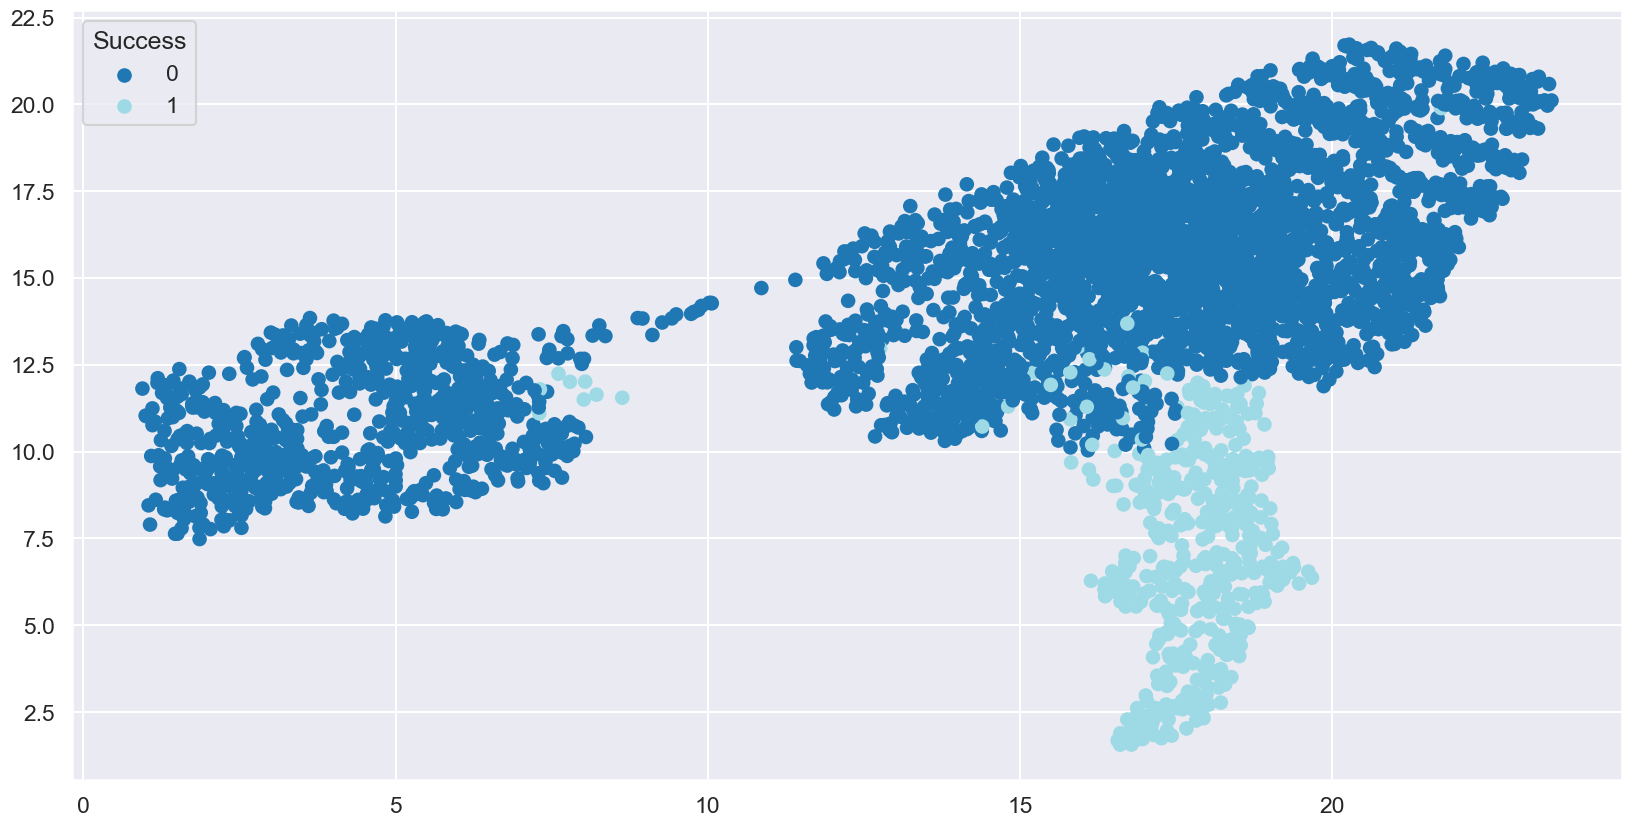

In [48]:
umap_object = umap.UMAP(n_neighbors=160, min_dist=1, random_state=16, n_jobs=-1)
umap_embedding = umap_object.fit_transform(data_rb)
visualize_dimensionality_reduction(umap_embedding, data['rb_ward2'])

---
---

## Yeo-Johnson

### KMeans

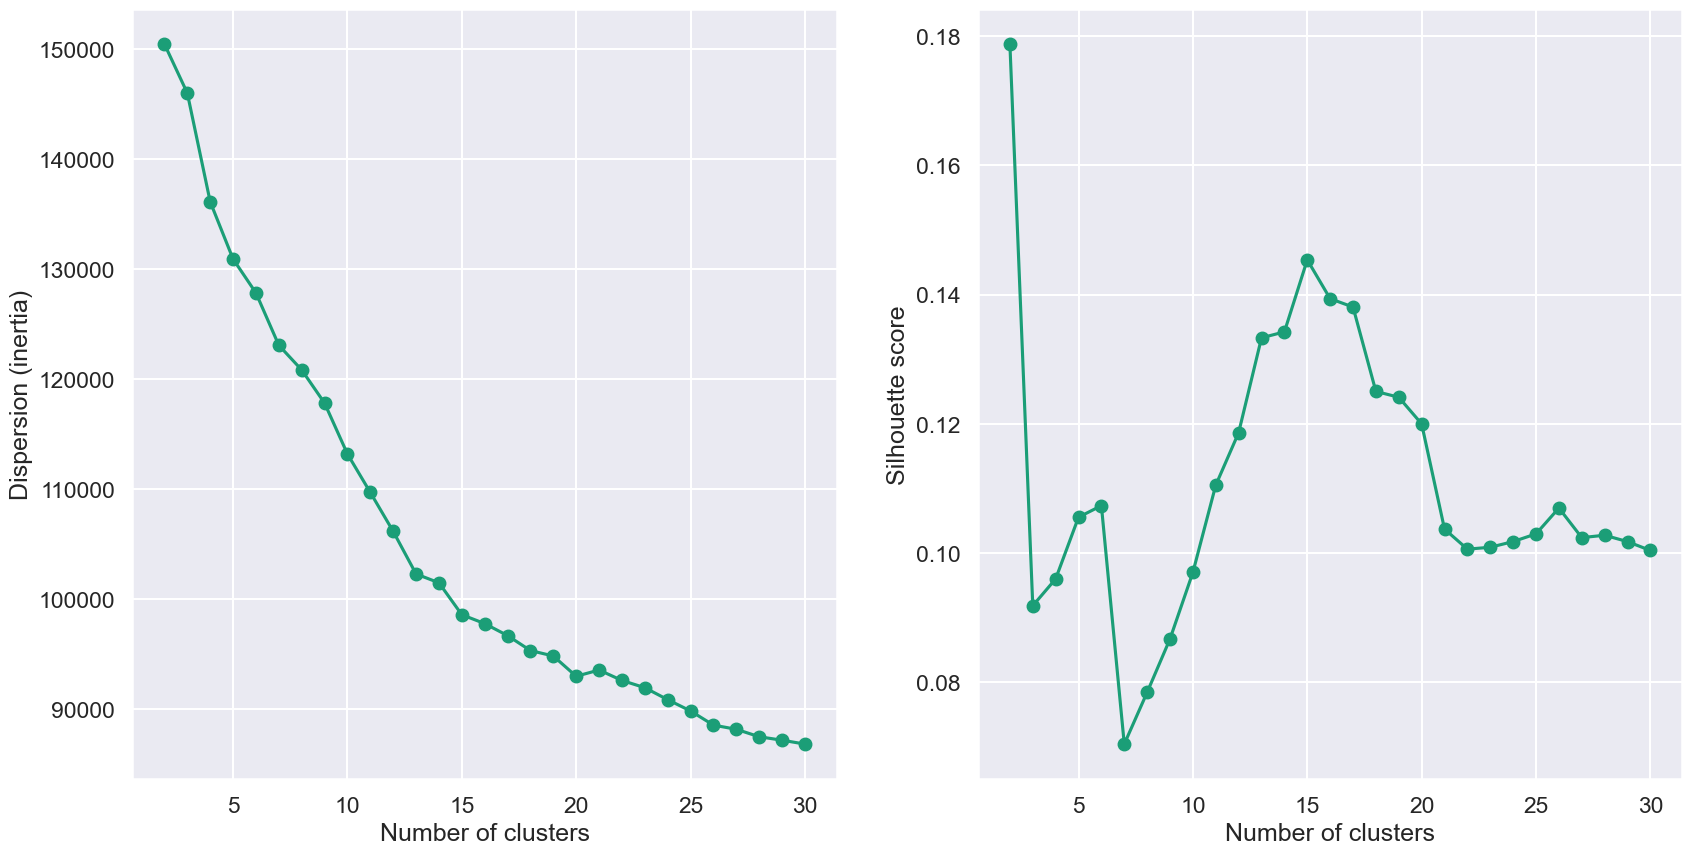

In [49]:
plot_inertia_and_silhouette(data_yj)

### Hierarchical

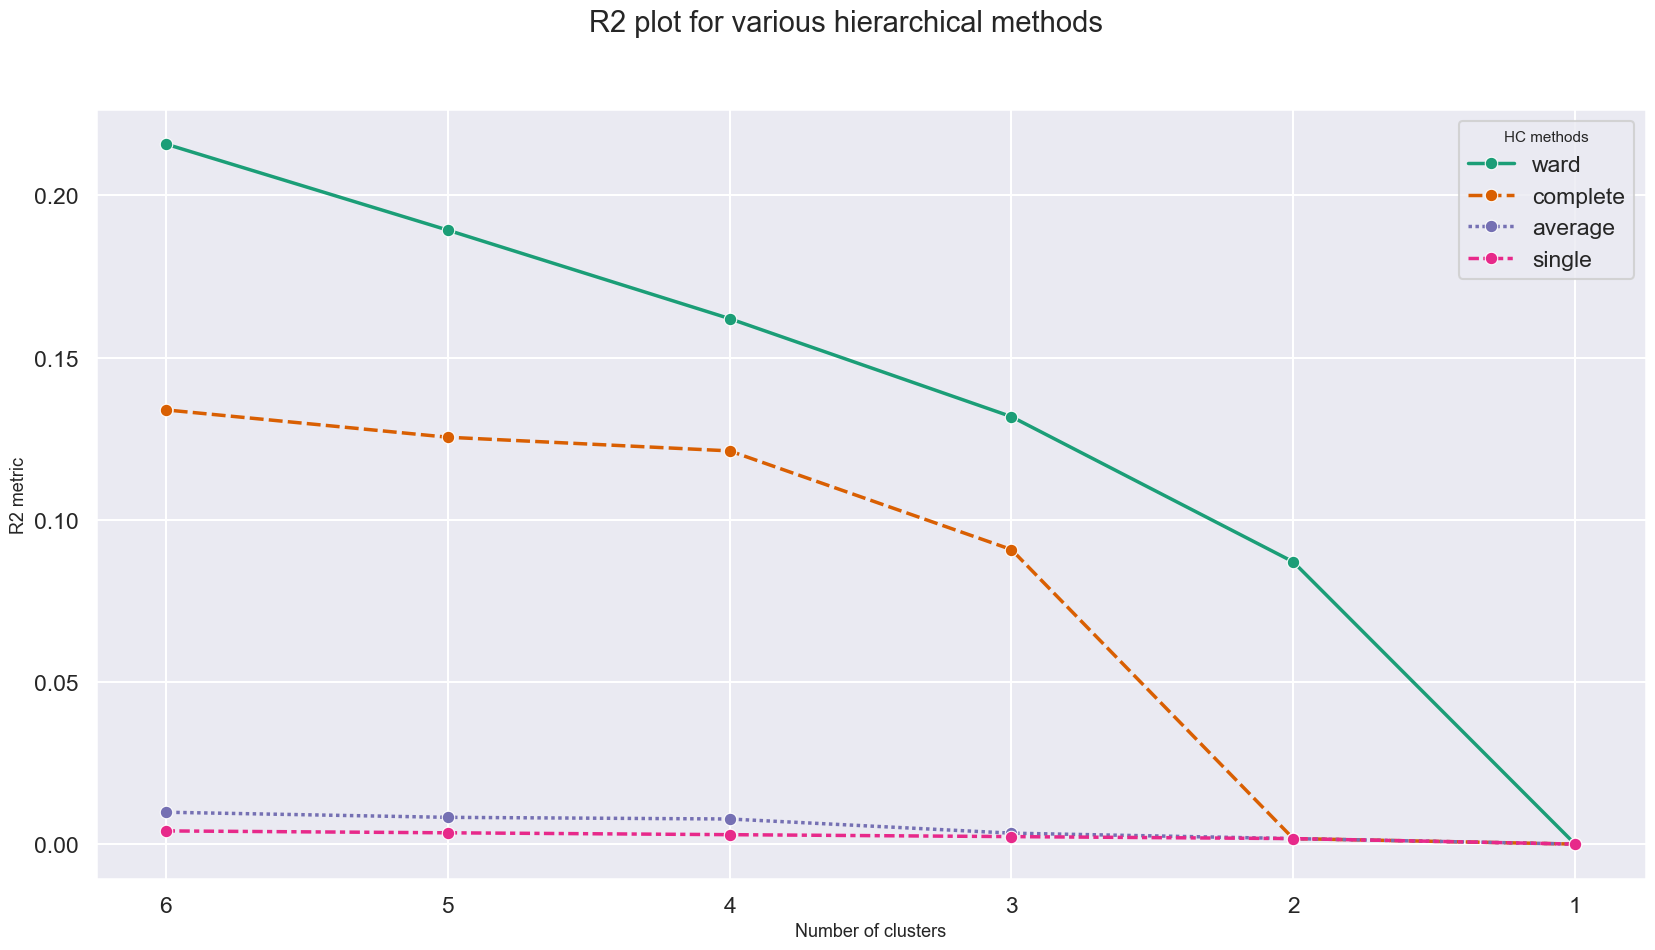

In [50]:
plot_r2_hc(data_yj)